In [1]:
# Basic modules
import os
import glob
import pandas as pd
import numpy as np
import scipy.optimize as so
from scipy.integrate import quad
import astropy.units as u
import astropy.constants as c 
import math
import re
import csv


# Modules for MESA
import mesa_reader as mr
import mesaPlot as mp
import mkipp
from mesa_data import * 
import kipp_data
# from mesa_star_class import MESA_STAR


# Other useful modules
from collections import namedtuple
import time
import datetime
from pathlib import Path 
import fnmatch 


# Modules for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.patches import PathPatch
import matplotlib.cm as cm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoLocator, AutoMinorLocator)
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap as cmap
from matplotlib.colors import BoundaryNorm as bn
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Basic Config

In [2]:
# Where MESA is located
mesa_dir = '/Users/schanlar/Software/mesa-r15140/' 

# Where data is located
work_dir = '/Volumes/SavvasExternal'

#he_tams_work_dir = '/Users/schanlar/aifa_models/hetams_vs_mass'
series1_tams_work_dir = os.path.join(work_dir, 'aifa_models/he_tams')
carbon_free_work_dir = os.path.join(work_dir, 'aifa_models/carbon_free')
fiducial_models_work_dir = os.path.join(work_dir, 'aifa_models/representatives')

series2_prefix = 'zsol_eta'
series2_suffix = ['0p1', '0p25', '0p5', '0p8', '1p0', '1p58']


series2_work_dir = []
for i in series2_suffix:
    series2_work_dir.append(os.path.join(work_dir, series2_prefix)+i)
    
    
    
# Where to save results
# plot_results_dir = '/Users/schanlar/Desktop/TNS_HeStars_figures'
plot_results_dir = '/Users/schanlar/Desktop/TNS_HeStars_figures/tests'
    

def make_canvas(fig_width=None, fig_height=None, columns=2, fontsize=18, clear=False):
    
    assert(columns in [1,2])

    if fig_width is None:
        if columns == 1:
            fig_width = 14.0
        else:
            fig_width = 7.0

    if fig_height is None:
        golden_ratio = (np.sqrt(5.0) - 1.0) / 2.0    
        fig_height = fig_width * golden_ratio 



    params = {
        'font.family': 'sans-serif',
        'font.sans-serif' : ['Times New Roman'],
        'font.size' : fontsize,
        "figure.figsize":[fig_width, fig_height],
        'axes.labelsize' : fontsize,
        'axes.titlesize' : fontsize,
        'xtick.labelsize' : fontsize,
        'ytick.labelsize' : fontsize,
        'legend.fontsize' : fontsize,
        'axes.linewidth' : 1,
        'lines.linewidth' : 2.5,
        'savefig.dpi' : 300
    }
    plt.rcParams.update(params)
    
    ax = plt.gca()
    ax.tick_params(direction='in',length=8,top=True,right=True)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')
    plt.locator_params(nbins=14)
    
    if clear:
        plt.clf()

## Luminosity / Teff / Mass-loss / Radius vs Remaining time of evolution

In [3]:
def vink2001(logTeff,logL,mass,ZdivZsun):
    #print(ZdivZsun)
    temp = np.power(10,logTeff)
    LdivLsun = np.power(10,logL)
    if temp>27500:
        alfa = 1
    elif temp<22500:
        alfa = 0
    else:
        Teff_jump = 1e3*(61.2e0 + 2.59e0*(-13.636e0 + 0.889e0*np.log10(ZdivZsun)))
        dT = 100e0
        if (temp > Teff_jump + dT):
            alfa = 1
        elif (temp < Teff_jump - dT):
            alfa = 0
        else:
            alfa = (temp - (Teff_jump - dT)) / (2*dT)
    if (alfa > 0):
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc*np.power(ZdivZsun,0.13e0)
        logMdot = -6.697e0 + 2.194e0*np.log10(LdivLsun/1e5) - 1.313e0*np.log10(mass/30) - 1.226e0*np.log10(vinf_div_vesc/2e0) + 0.933e0*np.log10(temp/4e4) - 10.92e0*np.power(np.log10(temp/4e4),2) + 0.85e0*np.log10(ZdivZsun)
        w1 = np.power(10,logMdot)
    else:
        w1 = 0
    if (alfa < 1):
        vinf_div_vesc = 1.3e0
        vinf_div_vesc = vinf_div_vesc*np.power(ZdivZsun,0.13e0)
        logMdot = -6.688e0 + 2.210e0*np.log10(LdivLsun/1e5) - 1.339e0*np.log10(mass/30) - 1.601e0*np.log10(vinf_div_vesc/2e0) + 1.07e0*np.log10(temp/2e4)  + 0.85e0*np.log10(ZdivZsun)
        w2 = np.power(10,logMdot)
    else:
        w2 = 0
    w = alfa*w1 + (1 - alfa)*w2
    w = np.log10(w)
    return w


def nugislamers(logL,Y,Z):
    temp = np.power(10,logTeff)
    LdivLsun = np.power(10,logL)
    w = 1e-11 * np.power(LdivLsun,1.29e0) * np.power(Y,1.7e0) * np.sqrt(Z)
    w = np.log10(w)
    return w


def deJager(logL,logTeff):
    temp = np.power(10,logTeff)
    LdivLsun = np.power(10,logL)
    log10w = 1.769e0*np.log10(LdivLsun) - 1.676e0*np.log10(temp) - 8.158e0
    return log10w

In [4]:
history_path = os.path.join(series2_work_dir[4], '2.5000_0.0200_1.0000/LOGS/history.data')
profile = mr.MesaData(history_path).data
max_age = max(profile("star_age"))
remaining_time_func = lambda x: np.log10(max(x)+0.01 - x)

<Figure size 720x720 with 0 Axes>

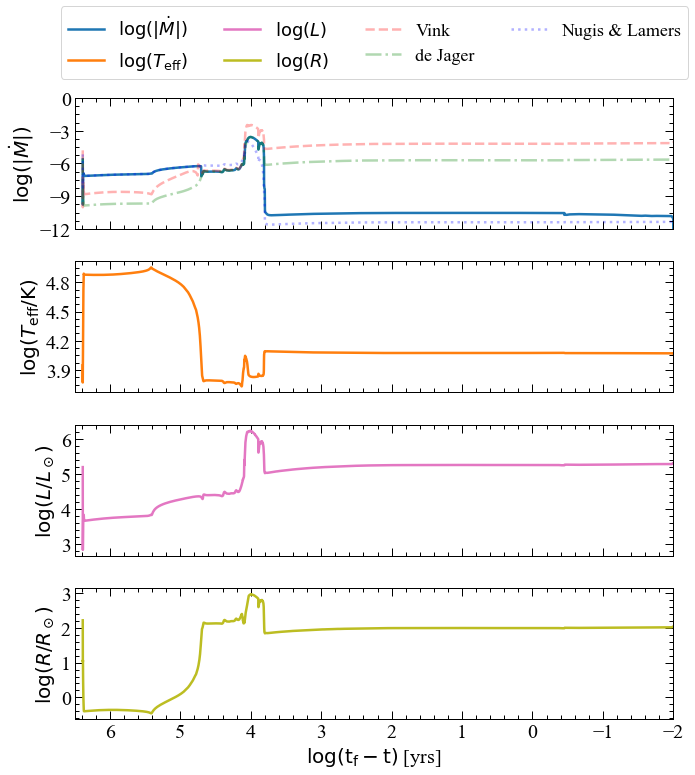

In [7]:
fontsize = 20
make_canvas(fig_width=10, fig_height=10, fontsize=fontsize, clear=True)


logTeff = profile('log_Teff')
log_L = profile('log_L')
mass = profile('star_mass')
surface_he4 = profile("surface_he4")
age = profile('star_age')

ZdivZsun = 0.02/0.014
vink = []
nugis = []
de_Jager = []

for i in range(0,len(mass)):
    a = vink2001(logTeff[i],log_L[i],mass[i],ZdivZsun)
    vink.append(a)
    b = nugislamers(log_L[i],surface_he4[i],0.02)
    nugis.append(b)
    c = deJager(log_L[i],logTeff[i])
    de_Jager.append(c)


fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True)

ax0.set_ylabel(r'$\log(|\dot{M}|)$', color='k')
ax0.set_ylim([-12,0])
ax0.set_xlim([-2.0,6.5])
ax0.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax0.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax0.xaxis.set_major_locator(plt.MaxNLocator(10))
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_major_locator(plt.MaxNLocator(4))
ax0.yaxis.set_minor_locator(AutoMinorLocator())

ax0.plot(remaining_time_func(profile("star_age")), profile("log_abs_mdot"), color='tab:blue', linewidth=2.5, label=r'$\log(|\dot{M}|)$')




ax1.set_ylabel(r'$\log(T_{\rm eff} / \rm K)$', color='k')
ax1.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax1.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.plot(remaining_time_func(profile("star_age")), profile("log_Teff"),color='tab:orange', linewidth=2.5, label=r'$\log(T_{\rm eff})$')



ax2.set_ylabel(r'$\log(L/L_\odot)$', color='k')  
ax2.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax2.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax2.plot(remaining_time_func(profile("star_age")), profile("log_L"), color='tab:pink', linewidth=2.5, label=r'$\log(L)$')



ax3.set_xlabel(r"$\rm \log (t_f-t)$ [yrs]")
ax3.set_ylabel(r'$\log(R/R_\odot)$', color='k') 
ax3.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax3.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_major_locator(plt.MaxNLocator(4))
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax3.plot(remaining_time_func(profile("star_age")), profile("log_R"), color='tab:olive', linewidth=2.5, label=r'$\log(R)$')




ax4 = ax0.twinx()
ax4.set_yticklabels([])
ax4.set_ylim([-12,0])
ax4.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax4.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax4.xaxis.set_major_locator(plt.MaxNLocator(10))
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_major_locator(plt.MaxNLocator(4))
ax4.yaxis.set_minor_locator(AutoMinorLocator())

ax4.plot(remaining_time_func(profile("star_age")),vink,c="red",alpha=0.3,linewidth=2.5, ls="--", label='Vink')
ax4.plot(remaining_time_func(profile("star_age")),de_Jager,c="green",alpha=0.3,linewidth=2.5, ls="-.", label='de Jager')
ax4.plot(remaining_time_func(profile("star_age")),nugis,c="blue",alpha=0.3,linewidth=2.5, ls=':', label='Nugis & Lamers')




ax0.invert_xaxis()


fig.tight_layout() 
fig.legend(loc='upper center', bbox_to_anchor=(0.54, 1.1),
          ncol=4, fancybox=True, shadow=False, prop={'size':18})

# plt.savefig(os.path.join(plot_results_dir, 'envelope_evolution_grid.pdf'), dpi=300, bbox_inches='tight')

## He-TAMS vs Initial Mass

In [8]:
def power_law(x, a, k, c):
    """A simple power-law to fit data"""
    
    y = a * (x ** k) + c
    return y



mass_zlow_fov0, mass_zlow_fov1, mass_zlow_fov2 = [], [], []
tams_zlow_fov0, tams_zlow_fov1, tams_zlow_fov2 = [], [], []

mass_zim_fov0, mass_zim_fov1, mass_zim_fov2 = [], [], []
tams_zim_fov0, tams_zim_fov1, tams_zim_fov2 = [], [], []

mass_zsol_fov0, mass_zsol_fov1, mass_zsol_fov2 = [], [], []
tams_zsol_fov0, tams_zsol_fov1, tams_zsol_fov2 = [], [], []


sorted_paths = []
for i in glob.glob(series1_tams_work_dir+'/*'):

    sorted_paths.append(i)


sorted_paths = sorted(sorted_paths)

for model_path in sorted_paths:

    mass_str = model_path.split('/')[-1].split('_')[0]
    z_str = model_path.split('/')[-1].split('_')[1]
    fov_str = model_path.split('/')[-1].split('_')[2]

    # print(mass_str, z_str, fov_str)

    try:

        h = mr.MesaData(os.path.join(model_path, 'history.data'))

    except Exception as e:

        print('Problem with: ', model_path)
        print(e)

    if z_str == '0.0001' and fov_str == '0.0000':
        mass_zlow_fov0.append(h.data('star_mass')[0])
        tams_zlow_fov0.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0001' and fov_str == '0.0140':
        mass_zlow_fov1.append(h.data('star_mass')[0])
        tams_zlow_fov1.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0001' and fov_str == '0.0160':
        mass_zlow_fov2.append(h.data('star_mass')[0])
        tams_zlow_fov2.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0010' and fov_str == '0.0000':
        mass_zim_fov0.append(h.data('star_mass')[0])
        tams_zim_fov0.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0010' and fov_str == '0.0140':
        mass_zim_fov1.append(h.data('star_mass')[0])
        tams_zim_fov1.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0010' and fov_str == '0.0160':
        mass_zim_fov2.append(h.data('star_mass')[0])
        tams_zim_fov2.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0200' and fov_str == '0.0000':
        mass_zsol_fov0.append(h.data('star_mass')[0])
        tams_zsol_fov0.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0200' and fov_str == '0.0140':
        mass_zsol_fov1.append(h.data('star_mass')[0])
        tams_zsol_fov1.append(h.data('star_age')[-1] / (10**6))

    elif z_str == '0.0200' and fov_str == '0.0160':
        mass_zsol_fov2.append(h.data('star_mass')[0])
        tams_zsol_fov2.append(h.data('star_age')[-1] / (10**6))

    else:
        print('Something went wrong with: ', model_path)

<Figure size 504x311.489 with 0 Axes>

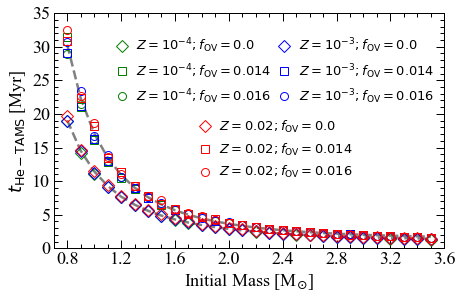

In [13]:
s=8
make_canvas(clear=True)


fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'$t_{\rm He-TAMS}$ [Myr]')

ax.set_xlim(0.7, 3.6)
ax.set_ylim(0.0, 35.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())


# Average values from individual fittings
y_fit_fov0 = [power_law(i, 10.538, -2.43, 0.931) for i in mass_zim_fov0]
y_fit_fov2 = [power_law(j, 15.93, -2.702, 1.193) for j in mass_zim_fov2]

plt.plot(mass_zim_fov0, y_fit_fov0, c='grey', ls='--', lw=2.5)
plt.plot(mass_zim_fov2, y_fit_fov2, c='grey', ls='--', lw=2.5)



plot_lines = []
# ax.plot(mass_zlow_fov0, tams_zlow_fov0, s=s, marker = 'D', facecolors='none', edgecolors='g', ls='')
l1, = ax.plot(mass_zlow_fov0, tams_zlow_fov0, marker='D', fillstyle='none', markeredgecolor='g', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zlow_fov0, tams_zlow_fov0)
# print(popt)
# plt.plot(mass_zlow_fov0, power_law(mass_zlow_fov0, *popt), ls='--')



l2, = ax.plot(mass_zlow_fov1, tams_zlow_fov1, marker='s', fillstyle='none', markeredgecolor='g', markersize = s,  ls='')
# popt, pcov = so.curve_fit(power_law, mass_zlow_fov1, tams_zlow_fov1)
# print(popt)
# plt.plot(mass_zlow_fov1, power_law(mass_zlow_fov1, *popt), ls='--')



l3, = ax.plot(mass_zlow_fov2, tams_zlow_fov2, marker='o', fillstyle='none', markeredgecolor='g', markersize = s,  ls='')
# popt, pcov = so.curve_fit(power_law, mass_zlow_fov2, tams_zlow_fov2)
# print(popt)
# plt.plot(mass_zlow_fov2, power_law(mass_zlow_fov2, *popt), ls='--')

plot_lines.append([l1,l2,l3])

ax.legend(plot_lines[0], [r'$Z=10^{-4};f_{\rm OV} = 0.0$', r'$Z=10^{-4};f_{\rm OV} = 0.014$', r'$Z=10^{-4};f_{\rm OV} = 0.016$'],
          loc='upper center', frameon=False, bbox_to_anchor=(0.35, 0.95), handletextpad=0.1, prop={'size':13})




l1, = ax.plot(mass_zim_fov0, tams_zim_fov0, marker='D', fillstyle='none', markeredgecolor='b', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zim_fov0, tams_zim_fov0)
# print(popt)
# plt.plot(mass_zim_fov0, power_law(mass_zim_fov0, *popt), ls='--')



l2, = ax.plot(mass_zim_fov1, tams_zim_fov1, marker='s', fillstyle='none', markeredgecolor='b', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zim_fov1, tams_zim_fov1)
# print(popt)
# plt.plot(mass_zim_fov1, power_law(mass_zim_fov1, *popt), ls='--')



l3, = ax.plot(mass_zim_fov2, tams_zim_fov2, marker='o', fillstyle='none', markeredgecolor='b', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zim_fov2, tams_zim_fov2)
# print(popt)
# plt.plot(mass_zim_fov2, power_law(mass_zim_fov2, *popt), ls='--')

plot_lines.append([l1,l2,l3])

leg2 = Legend(ax, plot_lines[1], [r'$Z=10^{-3};f_{\rm OV} = 0.0$', r'$Z=10^{-3};f_{\rm OV} = 0.014$', r'$Z=10^{-3};f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.765, 0.95), handletextpad=0.1, prop={'size':13})
ax.add_artist(leg2)




l1, = ax.plot(mass_zsol_fov0, tams_zsol_fov0, marker='D', fillstyle='none', markeredgecolor='r', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zsol_fov0, tams_zsol_fov0)
# print(popt)
# plt.plot(mass_zsol_fov0, power_law(mass_zsol_fov0, *popt), ls='--')


l2, = ax.plot(mass_zsol_fov1, tams_zsol_fov1, marker='s', fillstyle='none', markeredgecolor='r', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zsol_fov1, tams_zsol_fov1)
# print(popt)
# plt.plot(mass_zsol_fov1, power_law(mass_zsol_fov1, *popt), ls='--')


l3, = ax.plot(mass_zsol_fov2, tams_zsol_fov2, marker='o', fillstyle='none', markeredgecolor='r', markersize = s, ls='')
# popt, pcov = so.curve_fit(power_law, mass_zsol_fov2, tams_zsol_fov2)
# print(popt)
# plt.plot(mass_zsol_fov2, power_law(mass_zsol_fov2, *popt), ls='--')

plot_lines.append([l1,l2,l3])

leg3 = Legend(ax, plot_lines[2], [r'$Z=0.02;f_{\rm OV} = 0.0$', r'$Z=0.02;f_{\rm OV} = 0.014$', r'$Z=0.02;f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.56, 0.6), handletextpad=0.1, prop={'size':13})
ax.add_artist(leg3)



# plt.savefig(os.path.join(plot_results_dir, 'hetams_vs_mass.pdf'), dpi=300, bbox_inches='tight')

## Hertzprung-Russel Diagrams

In [14]:
from astropy.constants import sigma_sb, R_sun, L_sun

def f(R, T):
    """Stefan-Boltzmann law"""
    
    L = 4*np.pi * (R * R_sun.value)**2 * sigma_sb.value * (T**4)
    return L/L_sun.value



teff = np.linspace(2500, 10000000)

L0p000001 = [f(0.000001, i) for i in teff]
L0p00001 = [f(0.00001, i) for i in teff]
L0p0001 = [f(0.0001, i) for i in teff]
L0p001 = [f(0.001, i) for i in teff]
L0p01 = [f(0.01, i) for i in teff]
L0p1 = [f(0.1, i) for i in teff]
L1p0 = [f(1.0, i) for i in teff]
L10p0 = [f(10.0, i) for i in teff]
L100p0 = [f(100.0, i) for i in teff]
L1000p0 = [f(1000.0, i) for i in teff]
L10000p0 = [f(10000, i) for i in teff]



# LOAD DATA

hcowd = mr.MesaData(os.path.join(fiducial_models_work_dir, '0.8000_0.0001_0.0000/LOGS/history.data'))
hconewd = mr.MesaData(os.path.join(fiducial_models_work_dir, '1.4000_0.0010_0.0160/LOGS/history.data'))
hhybrid = mr.MesaData(os.path.join(fiducial_models_work_dir, '1.8000_0.0200_0.0140/LOGS/history.data'))
htsn = mr.MesaData(os.path.join(fiducial_models_work_dir, '2.5000_0.0200_0.0000/LOGS/history.data'))
hccsn = mr.MesaData(os.path.join(fiducial_models_work_dir, '3.1000_0.0001_0.0140/LOGS/history.data'))

<Figure size 504x311.489 with 0 Axes>

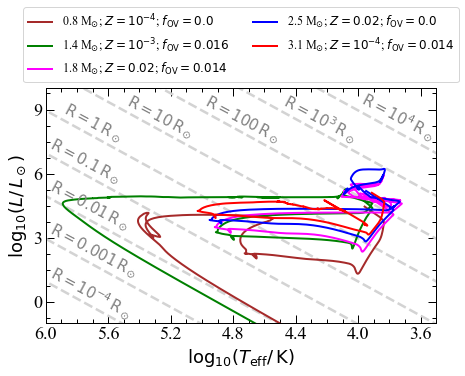

In [16]:
rot = -28
s = 15
make_canvas(clear=True)


fig, ax = plt.subplots()
ax.set_xlabel(r'$\log_{10} (T_{\rm eff} / \,\rm K)$')
ax.set_ylabel(r'$\log_{10} (L / \,L_\odot)$')

ax.set_xlim(6.0, 3.5)
ax.set_ylim(-1.0, 10.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator())




# ---------------------------------------------------------------------------------------------------------------------

# PLOT RADII

# plt.plot(np.log10(teff), np.log10(L0p000001), c = 'lightgrey', ls = '--')
# plt.text(5.65, -6.0, r'$\rm R = 10^{-6}\,R_\odot$', rotation = -18, fontsize = s, c='grey')

# ax.plot(np.log10(teff), np.log10(L0p00001), c = 'lightgrey', ls = '--')
# ax.text(5.65, -4.1, r'$\rm R = 10^{-5}\,R_\odot$', rotation = -18, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L0p0001), c = 'lightgrey', ls = '--')
ax.text(5.99, -0.75, r'$\rm R = 10^{-4}\,R_\odot$', rotation = rot, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L0p001), c = 'lightgrey', ls = '--')
ax.text(5.99, 1.2, r'$\rm R = 0.001\,R_\odot$', rotation = rot, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L0p01), c = 'lightgrey', ls = '--')
ax.text(5.99, 3.4, r'$\rm R = 0.01\,R_\odot$', rotation = rot, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L0p1), c = 'lightgrey', ls = '--')
ax.text(5.99, 5.6, r'$\rm R = 0.1\,R_\odot$', rotation = rot, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L1p0), c = 'lightgrey', ls = '--')
ax.text(5.9, 7.55, r'$\rm R = 1\,R_\odot$', rotation = rot, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L10p0), c = 'lightgrey', ls = '--')
ax.text(5.5, 7.7, r'$\rm R = 10\,R_\odot$', rotation = rot, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L100p0), c = 'lightgrey', ls = '--')
ax.text(5.0, 7.5, r'$\rm R = 100\,R_\odot$', rotation = rot, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L1000p0), c = 'lightgrey', ls = '--')
ax.text(4.5, 7.5, r'$\rm R = 10^3\,R_\odot$', rotation = rot, fontsize = s, c='grey')

ax.plot(np.log10(teff), np.log10(L10000p0), c = 'lightgrey', ls = '--')
ax.text(4.0, 7.6, r'$\rm R = 10^4\,R_\odot$', rotation = rot, fontsize = s, c='grey')
# ---------------------------------------------------------------------------------------------------------------------




# PLOT DATA
ax.plot(hcowd.data('log_Teff'), hcowd.data('log_L'), c = 'brown', lw=2, label = r'0.8 M$_{\odot}$; $Z=10^{-4}$; $f_{\rm OV}=0.0$')
ax.plot(hconewd.data('log_Teff'), hconewd.data('log_L'), c = 'green', lw=2, label = r'1.4 M$_{\odot}$; $Z=10^{-3}$; $f_{\rm OV}=0.016$')
ax.plot(hhybrid.data('log_Teff'), hhybrid.data('log_L'), c = 'magenta', lw=2, label = r'1.8 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.014$')
ax.plot(htsn.data('log_Teff'), htsn.data('log_L'), c = 'blue', lw=2, label = r'2.5 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.0$')
ax.plot(hccsn.data('log_Teff'), hccsn.data('log_L'), c = 'red', lw=2, label = r'3.1 M$_{\odot}$; $Z=10^{-4}$; $f_{\rm OV}=0.014$')

plt.gca().invert_xaxis()


ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.37),
           ncol=2, fancybox=True, shadow=False, prop={'size':12})
ax.invert_xaxis()

# plt.savefig(os.path.join(plot_results_dir, 'hrd_series1.pdf'), dpi=300, bbox_inches='tight')

## Density - Temperature History Plot

In [3]:
def find(pattern,path):
    result = []
    for root,dirs,files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name,pattern):
                result.append(os.path.join(root,name))
    return result

    
def capture_density(t,rho_0,Q,t_comp,ft):
    rho = rho_0/(1 + (3*c.k_B*t/Q)* np.log(2*np.log(2)*(c.k_B*t/(c.m_e*c.c**2))**5 * (Q/(c.k_B*t))**2 * (t_comp/ft)))
    return rho 

def nse_boundary(rho,T,s=1.0):
    rho = 10**rho
    T = (10**T)/1e9
    logrho = -(np.log10(np.exp(179./T - 40.5))-np.log10(s))/0.2
    return logrho
    
def logrhoc_logTc(data,
                  labels,
                  mesa_dir = mesa_dir, 
                  fontsize = 18,
                  colors=None,
                  lstyle=None,
                  xlim=None,
                  ylim=None,
                  ecap_density_corrections=False,
                  t_comp=1e4*u.yr):
    
    
    # hydrogen_burning_line = os.path.join(mesa_dir,'data/star_data/plot_info/hydrogen_burn.data')
    helium_burning_line = os.path.join(mesa_dir,'data/star_data/plot_info/helium_burn.data')
    carbon_burning_line = os.path.join(mesa_dir,'data/star_data/plot_info/carbon_burn.data')
    oxygen_burning_line = os.path.join(mesa_dir,'data/star_data/plot_info/oxygen_burn.data')
    electron_degeneracy_line = os.path.join(mesa_dir,'data/star_data/plot_info/psi4.data')
    
    
    # hburn = np.genfromtxt(hydrogen_burning_line)
    heburn = np.genfromtxt(helium_burning_line)
    cburn = np.genfromtxt(carbon_burning_line)
    oburn = np.genfromtxt(oxygen_burning_line)
    electron = np.genfromtxt(electron_degeneracy_line)

    # Radiation pressure line 
    logrho = np.arange(-9.0,10.0,0.1)
    logt = np.log10(3.2e7) + (logrho - np.log10(0.7))/3.0
    
    rhonse = nse_boundary(logrho,logt,s=1)
    plt.plot(rhonse,logt,ls=':',color='black')
    plt.text(5.25, 9.7, 'NSE', fontsize=fontsize,
               rotation=0, rotation_mode='anchor') 


    plt.plot(heburn[:,0],heburn[:,1],ls=':',color='black')
    plt.text(5.1, 7.95, 'He burn', fontsize=fontsize,
               rotation=0, rotation_mode='anchor')


    plt.plot(cburn[:,0],cburn[:,1],ls=':',color='black')
    plt.text(5.1, 8.67, 'C burn', fontsize=fontsize,
               rotation=0, rotation_mode='anchor')


    plt.plot(oburn[:,0],oburn[:,1],ls=':',color='black')
    plt.text(5.1, 9.05, 'O burn', fontsize=fontsize,
               rotation=0, rotation_mode='anchor')

    plt.plot(electron[:,0],electron[:,1],ls='--',color='black')

    plt.plot(logrho,logt,ls='--',color='black')
    plt.text(6.98, 9.5, r'$\epsilon_{\rm F}/k T \simeq 4$', fontsize=fontsize, rotation=0, rotation_mode='anchor')
    
    plt.text(5.25, 9.5, r'$P_{\rm rad}\simeq P_{\rm gas}$', fontsize=fontsize, rotation=0, rotation_mode='anchor')
    

    # Weak reaction lines 
    plt.text(9.05, 7.87, r'$^{25}{\rm Mg}\leftrightarrow ^{25}{\rm Na}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(9.25, 7.87, r'$^{23}{\rm Na} \leftrightarrow ^{23}{\rm Ne}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(9.65, 7.87, r'$^{24}{\rm Mg}\rightarrow ^{24}{\rm Na}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(9.75, 7.87, r'$^{24}{\rm Na}\rightarrow ^{24}{\rm Ne}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(9.85, 7.87, r'$^{25}{\rm Na}\leftrightarrow ^{25}{\rm Ne}$', fontsize=fontsize, rotation=90,verticalalignment='bottom')
    plt.text(10.00, 7.87, r'$^{20}{\rm Ne}\rightarrow ^{20}{\rm F}\rightarrow  ^{20}{\rm O}$', fontsize=fontsize, rotation=90,color='black',verticalalignment='bottom')
    
    
    if ecap_density_corrections:
        t = np.arange(7.5,11,0.1)
        t = 10**t * u.K
        rho_ce = capture_density(t,10**9.96,7.025*u.MeV,t_comp,10**9.801*u.s)
        plt.fill_between(np.log10(rho_ce),np.log10(t.value),np.max(np.log10(t.value)), facecolor="none", hatch="....", edgecolor="gray", linewidth=0.0)
        plt.fill_between([9.96,13],0,15,facecolor="none", hatch="....", edgecolor="gray", linewidth=0.0)
        
        plt.text(10.22, 8.6, r'ECSNe', 
                {'color': 'black', 'ha': 'center', 'va': 'center','fontsize': fontsize,'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})
        
    else:
        #plt.axvline(x=9.96,color='gray',ls='--')
        plt.fill_between([9.96,13],0,15,facecolor="none", hatch="....", edgecolor="gray", linewidth=0.0)
        
        plt.text(10.2, 9.05, r'ECSNe', 
                {'color': 'black', 'ha': 'center', 'va': 'center','fontsize': fontsize,'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})
    
   # now loop over data 
    for i in range(len(data)):
        d = data[i]
        if lstyle !=None:
            ls = lstyle[i]
        else:
            ls = '-'
        if colors !=None:
            color = colors[i]
        else:
            color=np.random.rand(3,1)
        if i==4: #2
            #pass
            plt.plot(d('log_center_Rho')[:],d('log_center_T')[:],label=labels[i],color=color,ls=ls, linewidth=2.5)
        else:
            plt.plot(d('log_center_Rho'),d('log_center_T'),label=labels[i],color=color,ls=ls, linewidth=2.5)
        
    
    # frame & labels 
    xlabel = r'$\log (\rho_{\rm c} / {\rm g}\,{\rm cm}^{-3})$'
    ylabel = r'$\log (T_{\rm c} / {\rm K})$'
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize) 
    
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim([5,10.5])
    if ylim:
        plt.ylim(ylim)
    else:
        plt.ylim([7.5,10.0])

In [4]:
data = [
        mr.MesaData(os.path.join(fiducial_models_work_dir, '0.8000_0.0001_0.0000/LOGS/history.data')).data,
        mr.MesaData(os.path.join(fiducial_models_work_dir, '1.4000_0.0010_0.0160/LOGS/history.data')).data,
        mr.MesaData(os.path.join(fiducial_models_work_dir, '1.8000_0.0200_0.0140/LOGS/history.data')).data,
        mr.MesaData(os.path.join(fiducial_models_work_dir, '2.5000_0.0200_0.0000/LOGS/history.data')).data,
        mr.MesaData(os.path.join(carbon_free_work_dir, '2.5000_0.0200_0.0000/LOGS/history.data')).data,
        mr.MesaData(os.path.join(fiducial_models_work_dir, '3.1000_0.0001_0.0140/LOGS/history.data')).data
    ]
        
labels = [
          r'0.8 M$_{\odot}$; $Z=0.0001$; $f_{\rm OV}=0.0$',
          r'1.4 M$_{\odot}$; $Z=0.001$;$f_{\rm OV}=0.016$',
          r'1.8 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.014$',
          r'2.5 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.0$',
          r'2.5 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.0$; no carbon reactions',
          r'3.1 M$_{\odot}$; $Z=0.0001$; $f_{\rm OV}=0.014$'
    ]

colors = ['brown','green', 'magenta', 'blue', 'blue', 'red']
lstyle = ['-', '-', '-', '-', '--', '-'] 

<ipython-input-3-61e098142b71>:17: RuntimeWarning: overflow encountered in exp
  logrho = -(np.log10(np.exp(179./T - 40.5))-np.log10(s))/0.2


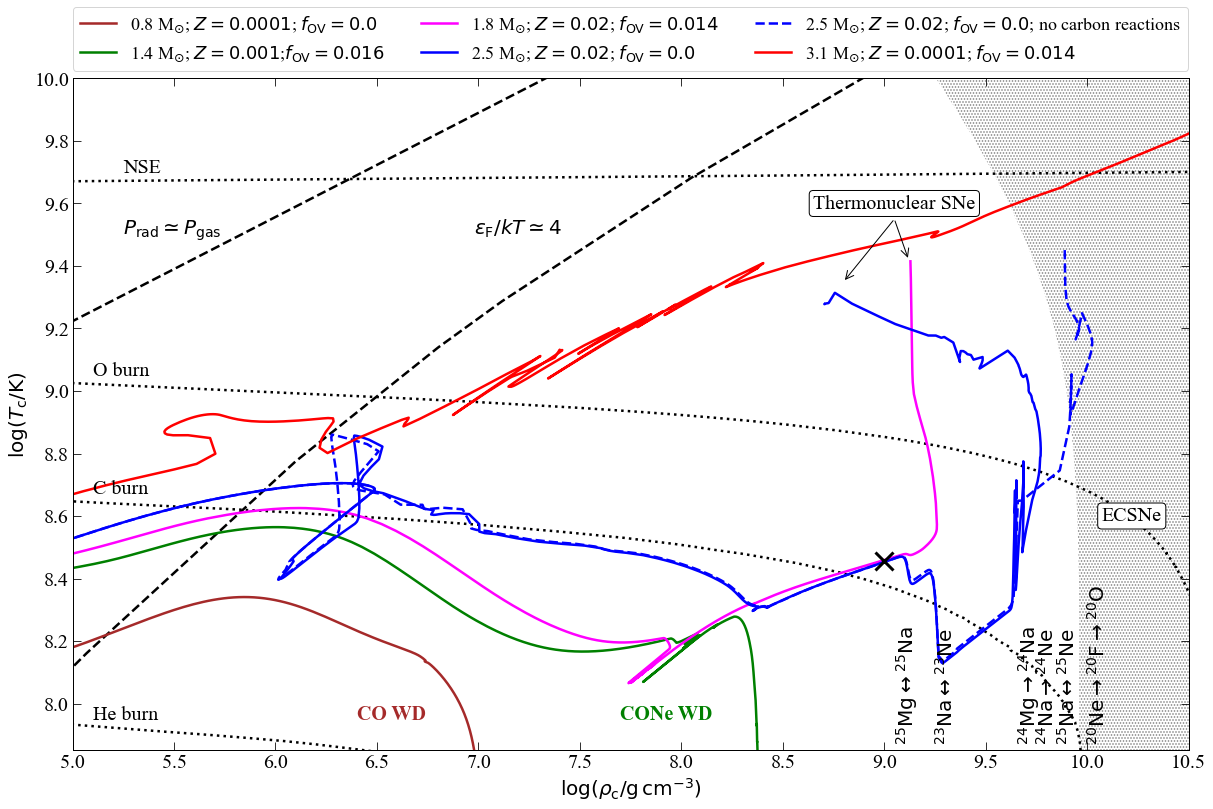

In [6]:
fontsize=20
make_canvas(fig_width=20, columns=1, fontsize=fontsize)

logrhoc_logTc(data, labels,
              colors=colors, lstyle=lstyle,
              ecap_density_corrections=True, 
              fontsize=fontsize,
              xlim=[5.0, 10.5], ylim=[7.85, 10.0]
             )

# Arbitrary location prior to Urca process
# At this density we calculate the amount of 
# residual carbon
plt.plot(9.0, 8.455, 'x', markersize=18, color='k', mew=3)



    
plt.text(9.05, 9.60, r'Thermonuclear SNe', 
                {'color': 'black', 'ha': 'center', 'va': 'center','fontsize': fontsize,'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})
plt.annotate("",
            xy=(8.8, 9.35),
            xytext=(9.05, 9.55),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.annotate("",
            xy=(9.12, 9.42),
            xytext=(9.05, 9.55),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.text(6.4, 7.95, 'CO WD', color = 'brown', fontsize = fontsize, weight='bold')
plt.text(7.7, 7.95, 'CONe WD', color = 'green', fontsize = fontsize, weight='bold')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
           ncol=3, fancybox=True, shadow=False, prop={'size': 18}) 

# plt.savefig(os.path.join(plot_results_dir, "RhoT_series1_final.pdf"), dpi=300, bbox_inches='tight')

In [7]:
data2 = [
        mr.MesaData(os.path.join(fiducial_models_work_dir, '2.5000_0.0200_0.0000/LOGS/history.data')).data,
        mr.MesaData(os.path.join(series2_work_dir[1], '2.0000_0.0200_0.2500/LOGS/history.data')).data,
        mr.MesaData(os.path.join(series2_work_dir[3], '2.7000_0.0200_0.8000/LOGS/history.data')).data,
        mr.MesaData(os.path.join(series2_work_dir[5], '2.1000_0.0200_1.5800/LOGS/history.data')).data,
    ]
        
labels2 = [
          r'2.5 M$_{\odot}$; $Z=0.02$; $f_{\rm OV}=0.0$; $\eta=1.0$',
          r'2.0 M$_{\odot}$; $Z=0.02$, $f_{\rm OV}=0.0$; $\eta = 0.25$',
          r'2.7 M$_{\odot}$; $Z=0.02$, $f_{\rm OV}=0.0$; $\eta = 0.8$',
          r'2.1 M$_{\odot}$; $Z=0.02$, $f_{\rm OV}=0.0$; $\eta = 1.58$'
    ]



colors2 = ['grey','cyan', 'purple', 'coral']
lstyle2 = ['-.', '-', '-', '-'] 

<ipython-input-3-61e098142b71>:17: RuntimeWarning: overflow encountered in exp
  logrho = -(np.log10(np.exp(179./T - 40.5))-np.log10(s))/0.2


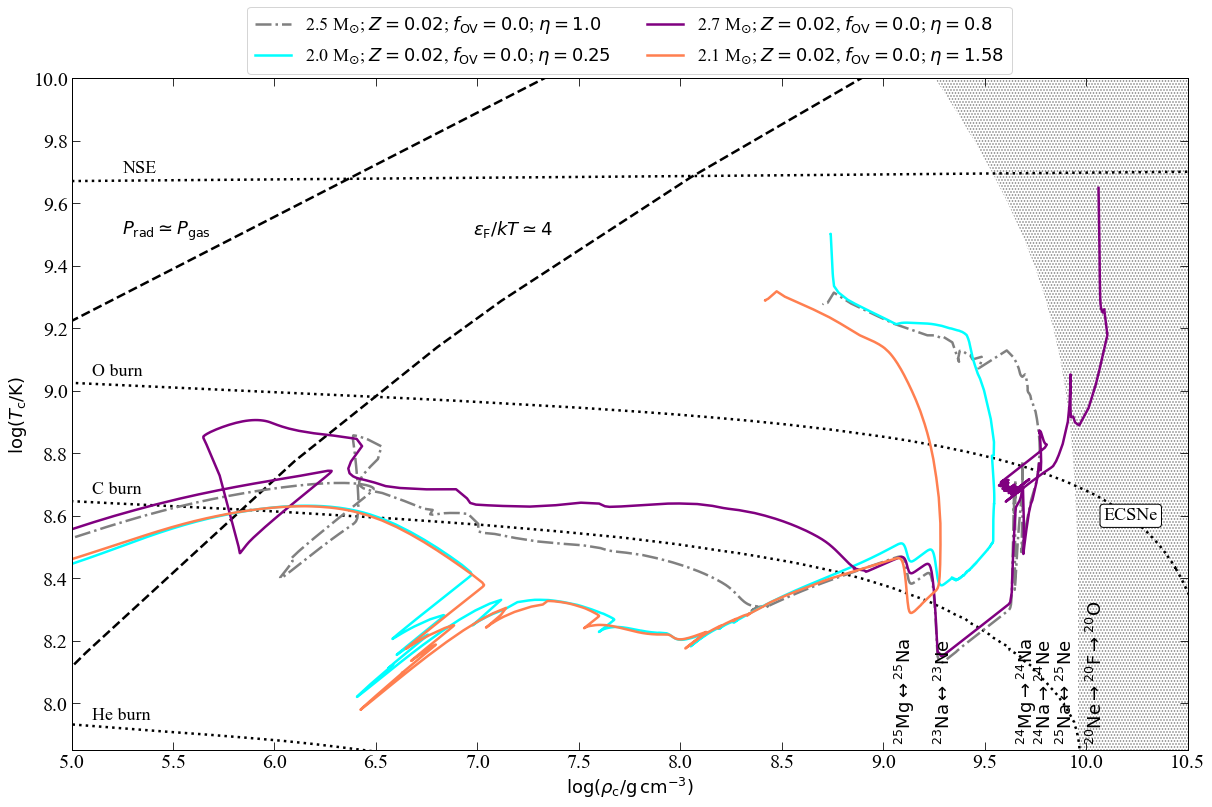

In [9]:
fontsize=20
make_canvas(fig_width=20, columns=1, fontsize=fontsize)


logrhoc_logTc(data2, labels2,
              colors=colors2, lstyle=lstyle2,
              ecap_density_corrections=True,
              xlim=[5.0, 10.5], ylim=[7.85, 10.0]
             )


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
           ncol=2, fancybox=True, shadow=False, prop={'size': 18}) 

# plt.savefig(os.path.join(plot_results_dir, "RhoT_series2_final.pdf"), dpi=300, bbox_inches='tight')

## Energetics & Nucleosynthesis

In [10]:
def potential_energy(rad,rho):
    udr = c.G*16./3. * np.pi**2. *rho**2 * rad**4 
    return np.trapz(udr,rad).to(u.erg)


def total_energy(Et,mass):
    Et = Et*u.erg/u.gram 
    mass = (mass*u.Msun)
    
    return (Et*mass).sum().to(u.erg)

def nuc_energy(A1,A2,mu1,mu2,X,mtot):
     # A1 -> A2 + energy
    energy_per_reaction = ((A2*mu1 - A1*mu2)*u.mu*c.c**2).to(u.erg)
    reactions_per_gram = (1*u.g / (A2*mu1*u.mu)).to(u.dimensionless_unscaled)/u.g
    mtot = u.Quantity(mtot,u.Msun)
    return (energy_per_reaction*reactions_per_gram *(X*mtot)).to(u.erg)


def kinetic_energy(p,Xige,Xime,Xfe=0.2):
    mass = p('dq')*p('mass')[0]
    Mige = p('mass')[0]*Xige
    Mime = p('mass')[0]*Xime
    c12  = 12.00000
    o16  = 15.994915
    ne20 = 19.992440
    na23 = 22.989769
    mg24 = 23.985042
    si28 = 27.976927
    fe56 = 55.934937
    ni56 = 55.942129
    
    E = 0.0
    msum = 0.0
    i=0
    for m in mass[::-1]:
        if msum <= Mige:
            E += nuc_energy(12,56,c12,ni56,p('c12')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(12,56,c12,fe56,p('c12')[::-1][i]*Xfe,m)
            E += nuc_energy(16,56,o16,ni56,p('o16')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(16,56,o16,fe56,p('o16')[::-1][i]*Xfe,m)   
            E += nuc_energy(20,56,ne20,ni56,p('ne20')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(20,56,ne20,fe56,p('ne20')[::-1][i]*Xfe,m) 
            E += nuc_energy(23,56,na23,ni56,p('na23')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(23,56,na23,fe56,p('na23')[::-1][i]*Xfe,m) 
            E += nuc_energy(24,56,mg24,ni56,p('mg24')[::-1][i]*(1-Xfe),m)
            E += nuc_energy(24,56,mg24,fe56,p('mg24')[::-1][i]*Xfe,m) 

        elif ((msum > Mige) & (msum <= (Mige+ Mime))):
            E += nuc_energy(12,28,c12,si28,p('c12')[::-1][i],m)
            E += nuc_energy(16,28,o16,si28,p('o16')[::-1][i],m)
            E += nuc_energy(20,28,ne20,si28,p('ne20')[::-1][i],m)
            E += nuc_energy(23,28,na23,si28,p('na23')[::-1][i],m)
            E += nuc_energy(24,28,mg24,si28,p('mg24')[::-1][i],m)
        i+=1
        msum += m 
    Eint=(p('total_energy')*mass* u.erg/u.gram * u.Msun).sum().to(u.erg)
    return E,Eint,E+Eint 

0.011193861980627905 0.014896454318648772 0.43902723269904925 0.4272706500845195 0.0372556430222872 0.10563299472351576 0.0016333780962264433 0.4963888549944387
0.005784567590108561 1.1087040239816525e-06 0.4427835516573616 0.2658081144519688 0.04984243365183304 0.18012784445895258 0.002288605281072805 0.498055445204058
0.08049741728517892 0.033857664912216576 0.4164771419792812 0.422622640406031 0.0370988975820531 0.20044067267130025 0.0019020381825963343 0.49825848059703187
0.05513860821665217 8.325408893832521e-05 0.5202355321359251 0.1043940393537097 0.040075015574717036 0.2385786786286394 0.00311608707034004 0.49852015095781427
0.003163559445577965 1.6970282196944294e-06 0.44190846533854344 0.4143911840494696 0.027306477747552987 0.06574991151235889 0.0007131095181906776 0.49490801622087793
0.003163242408180163 1.359246404136264e-05 0.3370403753980802 0.3280665081404776 0.027269673969181778 0.06619405297443096 0.0007125805667033821 0.4945910701528685
0.031239172048348526 0.0562746

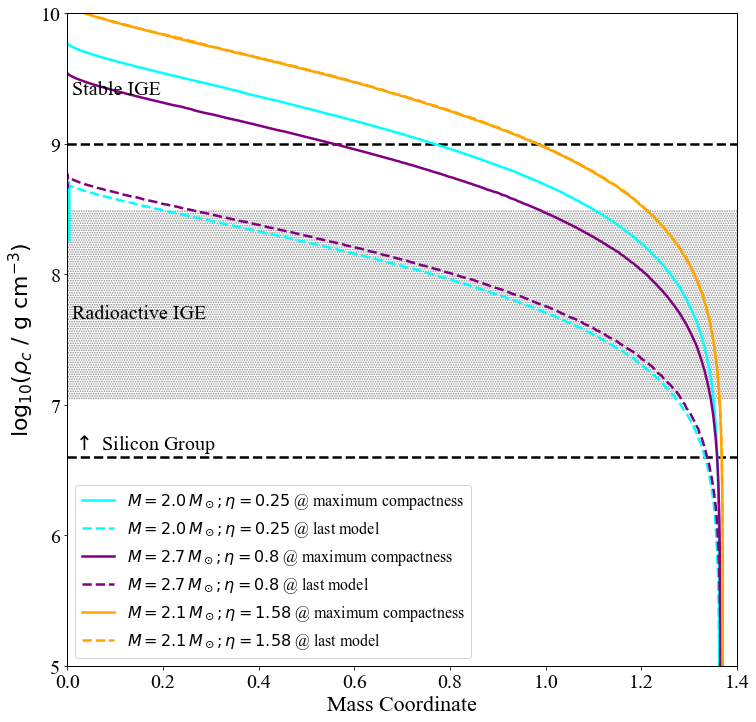

In [19]:
profiles = [mr.MesaData(os.path.join(series2_work_dir[4],'2.5000_0.0200_1.0000/profile_max_Rho.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[4],'2.5000_0.0200_1.0000/final_profile.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[1],'2.0000_0.0200_0.2500/profile_max_Rho.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[1],'2.0000_0.0200_0.2500/final_profile.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[3],'2.7000_0.0200_0.8000/profile_max_Rho.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[3],'2.7000_0.0200_0.8000/final_profile.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[5],'2.1000_0.0200_1.5800/profile_max_Rho.data')).data,
            mr.MesaData(os.path.join(series2_work_dir[5],'2.1000_0.0200_1.5800/final_profile.data')).data
            #mr.MesaData(os.path.join(series2_work_dir[5],'2.4000_0.0200_1.5800/final_profile.data')).data
           ]


def mass_average(profile,quantity='o16'):
    mass = profile('dq')*profile('mass')[0]
    
    return (profile(quantity)*mass).sum()/mass.sum()


def nucleosynthesis():
    plt.rcParams['figure.figsize'] = [12, 12]
    plt.rcParams['font.size'] = 22
    plt.xlabel(r'Mass Coordinate',fontsize=22)
    plt.ylabel(r'$\log_{10} (\rho_c \ / \rm \ g \ cm^{-3})$', fontsize=22)
    m = np.arange(0.0,1.5,0.1)
    rho  = np.arange(0,11.,0.01)
    

    
    plt.plot(m,np.ones_like(m)*9.0,ls='--',color='black')
    plt.text(0.01, 9.42, r'Stable IGE ', 
             {'color': 'black', 'ha': 'left', 'va': 'center','fontsize': 20})
    
    
    plt.text(0.01, 7.7, r'Radioactive IGE', 
             {'color': 'black', 'ha': 'left', 'va': 'center','fontsize': 20})
    
    
    
    plt.plot(m,np.ones_like(m)*6.6,ls='--',color='black')
    plt.text(0.01, 6.7, r'$\uparrow$ Silicon Group', 
             {'color': 'black', 'ha': 'left', 'va': 'center','fontsize': 20})
    plt.fill_between(m,7.04,8.49,facecolor="none", hatch=".....", edgecolor="gray", linewidth=0.0)
    
    plt.plot(profiles[0]('mass'),profiles[0]('logRho'),color='cyan',ls='-',label=r'$M=2.0\,M_\odot;\eta=0.25$ @ maximum compactness')
    plt.plot(profiles[1]('mass'),profiles[1]('logRho'),color='cyan',ls='--',label=r'$M=2.0\,M_\odot;\eta=0.25$ @ last model')
    plt.plot(profiles[2]('mass'),profiles[2]('logRho'),color='purple',ls='-',label=r'$M=2.7\,M_\odot;\eta=0.8$ @ maximum compactness')
    plt.plot(profiles[3]('mass'),profiles[3]('logRho'),color='purple',ls='--',label=r'$M=2.7\,M_\odot;\eta=0.8$ @ last model')
    plt.plot(profiles[4]('mass'),profiles[4]('logRho'),color='orange',ls='-',label=r'$M=2.1\,M_\odot;\eta=1.58$ @ maximum compactness')
    plt.plot(profiles[5]('mass'),profiles[5]('logRho'),color='orange',ls='--',label=r'$M=2.1\,M_\odot;\eta=1.58$ @ last model')
    plt.ylim([5,10.0])
    plt.xlim([0.0,1.4])
    plt.legend(prop={'size': 16},loc='lower left')
    
    # plt.savefig(os.path.join(plot_results_dir,'composition_series2.pdf'), dpi=300, bbox_inches='tight')

    
#make_canvas(fig_width=12, fig_height=12, fontsize=20)

nucleosynthesis()

for p in profiles:
    print(mass_average(p,quantity='c12'),p('c12')[-1],p('o16')[-1],p('ne20')[-1],mass_average(p,quantity='na23'),mass_average(p,quantity='mg24'),mass_average(p,quantity='mg25'),mass_average(p,quantity='ye'))

In [21]:
# kinetic_energy(profiles[8],0.7,0.8,Xfe=0.1)

for p in profiles:
    print(kinetic_energy(p, 0.7, 0.8, Xfe=0.1))

(<Quantity 1.40827715e+51 erg>, <Quantity -5.75274483e+50 erg>, <Quantity 8.33002665e+50 erg>)
(<Quantity 1.34801616e+51 erg>, <Quantity 3.43144981e+78 erg>, <Quantity 3.43144981e+78 erg>)
(<Quantity 1.81072861e+51 erg>, <Quantity -5.50460469e+50 erg>, <Quantity 1.26026814e+51 erg>)
(<Quantity 1.73337494e+51 erg>, <Quantity 1.81771796e+61 erg>, <Quantity 1.81771796e+61 erg>)
(<Quantity 1.39216772e+51 erg>, <Quantity -6.18315736e+50 erg>, <Quantity 7.73851983e+50 erg>)
(<Quantity 1.38242833e+51 erg>, <Quantity 2.83439507e+51 erg>, <Quantity 4.2168234e+51 erg>)
(<Quantity 1.4578726e+51 erg>, <Quantity -5.1292877e+50 erg>, <Quantity 9.44943828e+50 erg>)
(<Quantity 1.34745412e+51 erg>, <Quantity -4.01843301e+50 erg>, <Quantity 9.4561082e+50 erg>)


## Central abundances when log(Rho) \sim 9.0

In [5]:
#main_path = '/Volumes/SavvasExternal'
main_path = os.path.join(work_dir, series2_prefix)
model_id = []
c12_mass_fraction = []

# for path in glob.glob(main_path+'/zsol_*'):
for path in glob.glob(main_path+'*'):
    os.chdir(path)
    for data_dir in glob.glob(path+'/*'):
        if data_dir.startswith('2.', 36) or data_dir.startswith('2.', 37):
            logs_dir = os.path.join(data_dir, 'LOGS')
            h = mr.MesaData(os.path.join(logs_dir, 'history.data'))
            for idx,value in enumerate(h.data('log_center_Rho')):
                if math.isclose(value, 9.0, abs_tol=0.03):
                    model_id.append(data_dir.split('/')[-1])
                    c12_mass_fraction.append(h.data('center_c12')[idx])
                    break

In [6]:
m0p1, m0p25, m0p5, m0p8, m1p0, m1p58 = [], [], [], [], [], []
c12_eta0p1, c12_eta0p25, c12_eta0p5, c12_eta0p8, c12_eta1p0, c12_eta1p58 = [], [], [], [], [], []

for x,y in zip(model_id, c12_mass_fraction):
    if x.startswith('_0.1000', 13):
        m0p1.append(float(x.split('_')[0]))
        c12_eta0p1.append(round(y, 4))
    if x.startswith('_0.2500', 13):
        m0p25.append(float(x.split('_')[0]))
        c12_eta0p25.append(round(y, 4))
    if x.startswith('_0.5000', 13):
        m0p5.append(float(x.split('_')[0]))
        c12_eta0p5.append(round(y, 4))
    if x.startswith('_0.8000', 13):
        m0p8.append(float(x.split('_')[0]))
        c12_eta0p8.append(round(y, 4))
    if x.startswith('_1.0000', 13):
        m1p0.append(float(x.split('_')[0]))
        c12_eta1p0.append(round(y, 4))
    if x.startswith('_1.5800', 13):
        m1p58.append(float(x.split('_')[0]))
        c12_eta1p58.append(round(y, 4))

<Figure size 504x311.489 with 0 Axes>

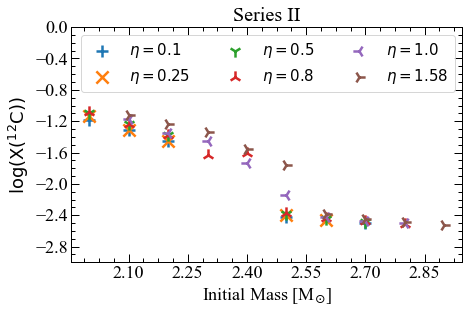

In [12]:
s = 150
make_canvas(clear=True)



fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'$\rm \log(X(^{12}C))$')

#ax.set_xlim(0.7, 3.6)
ax.set_ylim(-3.0, 0.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())


    
plt.scatter(m0p1, np.log10(c12_eta0p1), marker='+', s=s, 
            label = r'$\eta = 0.1$')
plt.scatter(m0p25, np.log10(c12_eta0p25), marker='x', s=s, 
            label = r'$\eta = 0.25$')
plt.scatter(m0p5, np.log10(c12_eta0p5), marker='1', s=s, 
            label = r'$\eta = 0.5$')
plt.scatter(m0p8, np.log10(c12_eta0p8), marker='2', s=s, 
            label = r'$\eta = 0.8$')
plt.scatter(m1p0, np.log10(c12_eta1p0), marker='3', s=s, 
            label = r'$\eta = 1.0$')
plt.scatter(m1p58, np.log10(c12_eta1p58), marker='4', s=s, 
            label = r'$\eta = 1.58$')



plt.legend(ncol=3, prop={'size':15})
plt.title('Series II', size=20)

# plt.savefig(os.path.join(plot_results_dir, 'c12_mass_fractions_series2.pdf'), dpi=300, bbox_inches='tight')

In [13]:
m_zlow_f0, m_zlow_f1, m_zlow_f2 = [], [], []
c12_zlow_f0, c12_zlow_f1, c12_zlow_f2 = [], [], []

m_zim_f0, m_zim_f1, m_zim_f2 = [], [], []
c12_zim_f0, c12_zim_f1, c12_zim_f2 = [], [], []

m_zsol_f0, m_zsol_f1, m_zsol_f2 = [], [], []
c12_zsol_f0, c12_zsol_f1, c12_zsol_f2 = [], [], []


with open('/Users/schanlar/Desktop/res_carbon.txt', 'r') as file:
    for line in file:
        if line.startswith('MODEL: 2.') and ('0.0001' in line) and ('0.0000' in line):
            #print(line)
            m_zlow_f0.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zlow_f0.append(float(c12_f.split(' ')[-1]))
            
        if line.startswith('MODEL: 2.') and ('0.0001' in line) and ('0.0140' in line):
            #print(line)
            m_zlow_f1.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zlow_f1.append(float(c12_f.split(' ')[-1]))
            
        if line.startswith('MODEL: 2.') and ('0.0001' in line) and ('0.0160' in line):
            #print(line)
            m_zlow_f2.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zlow_f2.append(float(c12_f.split(' ')[-1]))
            
        if line.startswith('MODEL: 2.') and ('0.0010' in line) and ('0.0000' in line):
            #print(line)
            m_zim_f0.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zim_f0.append(float(c12_f.split(' ')[-1]))
            
        if line.startswith('MODEL: 2.') and ('0.0010' in line) and ('0.0140' in line):
            #print(line)
            m_zim_f1.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zim_f1.append(float(c12_f.split(' ')[-1]))
            
        if line.startswith('MODEL: 2.') and ('0.0010' in line) and ('0.0160' in line):
            #print(line)
            m_zim_f2.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zim_f2.append(float(c12_f.split(' ')[-1]))
        
        if line.startswith('MODEL: 2.') and ('0.0200' in line) and ('0.0000' in line):
            #print(line)
            m_zsol_f0.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zsol_f0.append(float(c12_f.split(' ')[-1]))
            
        if line.startswith('MODEL: 2.') and ('0.0200' in line) and ('0.0140' in line):
            #print(line)
            m_zsol_f1.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zsol_f1.append(float(c12_f.split(' ')[-1]))
            
        if line.startswith('MODEL: 2.') and ('0.0200' in line) and ('0.0160' in line):
            #print(line)
            m_zsol_f2.append(float(line.split(' ')[1].split('_')[0]))
            c12_f = next(file)
            c12_zsol_f2.append(float(c12_f.split(' ')[-1]))


<Figure size 504x311.489 with 0 Axes>

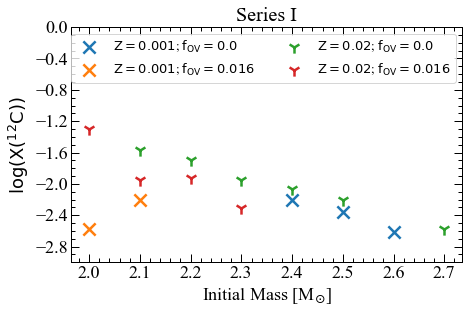

In [18]:
s = 150
make_canvas(clear=True)



fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'$\rm \log(X(^{12}C))$')

#ax.set_xlim(0.7, 3.6)
ax.set_ylim(-3.0, 0.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())

# plt.scatter(m_zlow_f0, np.log10(c12_zlow_f0), label='zlow;f0', marker = '+', s= s)
# plt.scatter(m_zlow_f1, np.log10(c12_zlow_f1), label='zlow;f1', marker = '+', s= s)
# plt.scatter(m_zlow_f2, np.log10(c12_zlow_f2), label='zlow;f2', marker = '+', s= s)

plt.scatter(m_zim_f0, np.log10(c12_zim_f0), label=r'$\rm Z = 0.001$; $\rm f_{OV} = 0.0$', marker = 'x', s= s)
# plt.scatter(m_zim_f1, np.log10(c12_zim_f1), label='zim;f1', marker = 'x', s= s)
plt.scatter(m_zim_f2, np.log10(c12_zim_f2), label=r'$\rm Z = 0.001$; $\rm f_{OV} = 0.016$', marker = 'x', s= s)

plt.scatter(m_zsol_f0, np.log10(c12_zsol_f0), label=r'$\rm Z = 0.02$; $\rm f_{OV} = 0.0$', marker = '1', s= s)
# plt.scatter(m1p0, np.log10(c12_eta1p0), label=r'$\rm Z = 0.02$; $\rm f_{OV} = 0.0$', marker = '1', s= s)
# # plt.scatter(m_zsol_f1, np.log10(c12_zsol_f1), label='zsol;f1', marker = '1', s= s)
plt.scatter(m_zsol_f2, np.log10(c12_zsol_f2), label=r'$\rm Z = 0.02$; $\rm f_{OV} = 0.016$', marker = '1', s= s)






plt.legend(ncol=2, prop={'size':13})
plt.title('Series I', size=20)


# plt.savefig(os.path.join(plot_results_dir, 'c12_mass_fractions_series1.pdf'), dpi=300, bbox_inches='tight')

## Kippenhahn diagrams

In [19]:
def get_burning_zones(history_paths, kipp_args, xlims = None):
    # Get burning zones and mass borders from history.data files

    xaxis_divide = kipp_args.xaxis_divide
    if kipp_args.xaxis == "star_age":
        if kipp_args.time_units == "1000 yr":
            xaxis_divide = 1000
        elif kipp_args.time_units == "Myr":
            xaxis_divide = 1e6
        elif kipp_args.time_units == "Gyr":
            xaxis_divide = 1e9

    print("Reading history data")
    burn_data = []
    histories = []
    for history_name in history_paths:
        history = mesa_data(history_name, read_data = False)
        columns = []
        for key in history.columns.keys():
            search_regex = "log_R|star_mass|model_number|star_age|.*core_mass|burn_type.*|"
            for extra_col in kipp_args.extra_history_cols:
                search_regex = search_regex + extra_col + "|"
            if kipp_args.yaxis == "radius":
                search_regex = search_regex + "burn_relr_top.*"
            else:
                search_regex = search_regex + "burn_qtop.*"
            if re.search(search_regex,key):
                columns.append(key)
        history.read_data(columns, clean_data = kipp_args.clean_data)
        histories.append(history)
    x_coords = []
    for history in histories:
        x_coords.extend(history.get(kipp_args.xaxis) / xaxis_divide)
    x_coords = kipp_args.function_on_xaxis(np.array(x_coords))
    y_coords = []
    if kipp_args.yaxis_normalize:
        y_coords = [1.0]*len(x_coords)
    elif kipp_args.yaxis == "radius":
        for history in histories:
            y_coords.extend(np.power(10,history.get('log_R')))
    else:
        for history in histories:
            y_coords.extend(history.get('star_mass'))

    print("Constructing burning regions")
    mesa_burn_zones = 0
    while True:
        try:
            mesa_burn_zones = mesa_burn_zones + 1
            burn_type = []
            burn_top = []
            for history in histories:
                burn_type.extend(history.get('burn_type_'+str(mesa_burn_zones)))
                if kipp_args.yaxis == "radius":
                     burn_top.extend(history.get('burn_relr_top_'+str(mesa_burn_zones)))
                else:
                     burn_top.extend(history.get('burn_qtop_'+str(mesa_burn_zones)))
            burn_data.append([burn_type, burn_top])
        except (Exception):
            #reached all burn zones included
            mesa_burn_zones = mesa_burn_zones - 1
            print("there are " + str(mesa_burn_zones) + " burning zones")
            break

    if kipp_args.yaxis == "radius":
        tolerance = kipp_args.radius_tolerance
    else:
        tolerance = kipp_args.mass_tolerance

    zones = []
    burn_types = []
    open_zones = []
    new_zones = []
    for i in range(1,len(x_coords)):
        current_x = x_coords[i]
        #ignore points outside of range, but include one outside each boundary
        #do not assume x_coords is in increasing order
        if xlims != None:
            if not xlims[0] <= current_x <= xlims[1]:
                if not ((i+1 < len(x_coords) and xlims[0] <= x_coords[i+1] <= xlims[1]) \
                        or (i-1 > 0 and xlims[0] <= x_coords[i-1] <= xlims[1])):
                    continue
        previous_x = x_coords[i-1]
        for j in range(0,mesa_burn_zones):
            burn_type = burn_data[j][0][i]
            if burn_type == 0 or burn_type == -1:
                continue 
            max_y_coord = burn_data[j][1][i]*y_coords[i]
            min_y_coord = 0
            if j > 0:
                min_y_coord = burn_data[j-1][1][i]*y_coords[i]
            #ignore too small regions
            if max_y_coord - min_y_coord < tolerance*y_coords[i]:
                continue
            zone_block = kipp_data.Zone_Block(previous_x, current_x, min_y_coord, max_y_coord)
            exists = False
            zones_to_merge = []
            for z in open_zones:
                if z.extend(zone_block.vertices[1], zone_block.vertices[1].prev_vertex, burn_type):
                    exists = True
                    z.new_blocks.append(zone_block)
                    zones_to_merge.append(z)
            #merge zones as needed
            for k in range(1,len(zones_to_merge)):
                zones_to_merge[0].merge_zone(zones_to_merge[k])
                open_zones.remove(zones_to_merge[k])
            #create zone if it has no predecesor
            if not exists:
                z = kipp_data.Zone(zone_block, burn_type)
                new_zones.append(z)
        open_zones.extend(new_zones)
        new_zones = []
        #separate zones which didn't continue here so we don't need to check them all the time
        for z in open_zones:
            z.switch_new_blocks()
        for z in open_zones:
            if len(z.last_blocks) == 0:
                zones.append(z.get_path())
                burn_types.append(z.mix_type)
                open_zones.remove(z)
        #order zones
        temp_open_zones = []
        while(len(open_zones)>0):
            min_y = -1
            j = -1
            for i, zone in enumerate(open_zones):
                for block in zone.last_blocks:
                    if block.vertices[0].coords[1] < min_y or min_y < 0:
                        min_y = block.vertices[0].coords[1]
                        j = i
            temp_open_zones.append(open_zones.pop(j))
        open_zones =temp_open_zones

    for z in open_zones:
        z.switch_new_blocks()
        zones.append(z.get_path())
        burn_types.append(z.mix_type)

    Burning_Zones = namedtuple('Burning_Zones', 'zones burn_types x_coords y_coords histories')
    return Burning_Zones(zones, burn_types, x_coords, y_coords, histories)

In [20]:
# log_directory = "/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS"
log_directory = os.path.join(series2_work_dir[4], '2.5000_0.0200_1.0000/LOGS')
history_file = os.path.join(log_directory, 'history.data')

/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS ['/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS']
/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS ['/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS']
Reading profile data
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not i

Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are not increasing in X coordinate!!!
Profiles are 

Text(2.5, 2.3, '')

<Figure size 504x311.489 with 0 Axes>

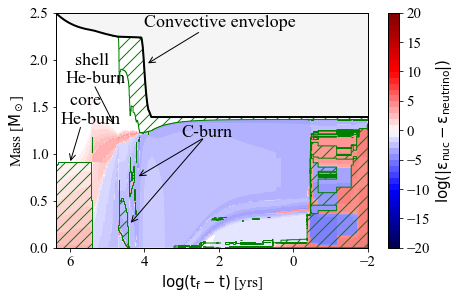

In [21]:
# Kipp diagram vs remaining time of evolution
remaining_time_func = lambda x: np.log10(max_age+0.01 - x)

mapa = 'seismic'

history = mesa_data(history_file, read_data_cols = ["star_mass", "star_age"])
max_mass = max(history.get("star_mass"))
max_age = max(history.get("star_age"))
min_age = min(history.get("star_age"))

mini, maxi = (-20,20)
step = 1
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(mini,maxi+step,step)
CS3 = plt.contourf(Z, levels, cmap=mapa)
plt.clf()
profile_paths = get_profile_paths([log_directory])
# if data is distributed among several history.data files, you can provide them
history_paths = [history_file]


# Arguments for plotter
# Mass vs remaining time
kipp_args = mkipp.Kipp_Args(
    logs_dirs = [log_directory],
    contour_colormap = mapa,
    xaxis = "star_age",
    time_units = "yr",
    function_on_xaxis = remaining_time_func,
    yaxis = "mass",
    # show_conv = True, 
    # show_therm = True, 
    # show_semi = False, 
    # show_over = False, 
    # show_rot = False,
    core_masses = ["total"],
    decorate_plot = False
)



xaxis_divide = kipp_args.xaxis_divide
if kipp_args.xaxis == "star_age":
    if kipp_args.time_units == "1000 yr":
        xaxis_divide = 1000
    elif kipp_args.time_units == "Myr":
        xaxis_divide = 1e6
    elif kipp_args.time_units == "Gyr":
        xaxis_divide = 1e9
        
        
        
# Canvas
golden_ratio = (np.sqrt(5.0) - 1.0) / 2.0
fig_width = 7.0
fig_height = fig_width * golden_ratio
fontsize = 15

params = {
    'font.family': 'sans-serif',
    'font.sans-serif' : ['Times New Roman'],
    'font.size' : fontsize,
    "figure.figsize":[fig_width, fig_height],
    'axes.labelsize' : fontsize,
    'axes.titlesize' : fontsize,
    'xtick.labelsize' : fontsize,
    'ytick.labelsize' : fontsize,
    'legend.fontsize' : fontsize,
    'axes.linewidth' : 1,
    'lines.linewidth' : 2.5
}
plt.rcParams.update(params)

fig = plt.figure()
axis = plt.gca()
colormapper = plt.get_cmap(mapa)



# Plotting burning zones
xyz_data = kipp_data.get_xyz_data(profile_paths, kipp_args)
burning_zones = get_burning_zones(history_paths, kipp_args, xlims = xyz_data.xlims)
for i,zone in enumerate(burning_zones.zones):
    color = ""
    x = (float(burning_zones.burn_types[i])+20.0)/40.0
    if x>1:
        x=0.9999999999
    if x<0:
        x=0
    color = colormapper(x)

    axis.add_patch(PathPatch(zone, color=color, alpha = 0.5, lw = 0))
    

# Plotting mixing zones
mixing_zones = kipp_data.get_mixing_zones(history_paths, kipp_args, xlims = xyz_data.xlims)
for i,zone in enumerate(mixing_zones.zones):
    color = ""
    # Convective mixing
    if mixing_zones.mix_types[i] == 1: #convection
        color = "green"
        hatch = "//"
        line  = 1
    # Overshooting 
    elif mixing_zones.mix_types[i] == 3: #overshooting
        color = "purple"
        hatch = "x"
        line  = 1
    # Semiconvective mixing
    # elif mixing_zones.mix_types[i] == 4: #semiconvection
        # color = '#f28123'
    # elif mixing_zones.mix_types[i] == 5: #thermohaline
        # color = '#ffc132'
    # elif mixing_zones.mix_types[i] == 6: #rotational mixing
        # color = '#087e8b'

    else:
        continue
        
    axis.add_patch(PathPatch(zone, fill=False, hatch = hatch, edgecolor=color, linewidth=line))
    
    
    
    
for i, x_coord in enumerate(mixing_zones.x_coords):
        if x_coord > xyz_data.xlims[1]:
            break
            
# I also fill with white above the plot to cover any remainer of the contour plot
axis.fill_between(mixing_zones.x_coords, max(mixing_zones.y_coords), mixing_zones.y_coords, color = "whitesmoke")
axis.plot(mixing_zones.x_coords[:i], mixing_zones.y_coords[:i], "k-")

# add core masses
if kipp_args.yaxis == "mass":
    for core_mass in kipp_args.core_masses:
        if core_mass == "He":
            field_name = "he_core_mass"
            color = "b:"
        elif core_mass == "C":
            field_name = "c_core_mass"
            color = "r:"
        elif core_mass == "O":
            field_name = "o_core_mass"
            color = "g:"
        elif core_mass == "total":
            field_name = "star_mass"
            color = "k"
            line = 2
        for history in mixing_zones.histories:
            axis.plot(kipp_args.function_on_xaxis(history.get(kipp_args.xaxis) / xaxis_divide), \
                    history.get(field_name), color, linewidth=line)
    
    


# Colorbar
bar = plt.colorbar(CS3)
bar.set_label(r"$\rm \log \left( |\epsilon_{\rm nuc} - \epsilon_{\rm neutrino}| \right)$")
axis.set_xlabel(r"$\rm \log (t_f-t)$ [yrs]")
axis.set_ylabel(r"Mass [$\rm M_\odot$]")
axis.set_xlim([remaining_time_func(max_age), remaining_time_func(min_age)])
axis.set_ylim([0.0, max_mass])

plt.gca().invert_xaxis()




# Annotate regions
text1 = '  core' + '\n' + 'He-burn'
text2 = '  shell' + '\n' + 'He-burn'
text3 = 'C-burn'
text4 = 'Convective envelope'


plt.text(6.25, 1.32, text1, fontsize='large')
plt.annotate("",
            xy=(6.0, 0.9),
            xytext=(5.7, 1.3),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.text(6.1, 1.75, text2, fontsize='large')
plt.annotate("",
            xy=(4.8, 1.3),
            xytext=(5.35, 1.73),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.text(3.0, 1.18, text3, fontsize='large')
plt.annotate("",
            xy=(4.4, 0.25),
            xytext=(2.4, 1.17),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
plt.annotate("",
            xy=(4.2, 0.75),
            xytext=(2.4, 1.17),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.text(4.0, 2.35, text4, fontsize='large')
plt.annotate("",
            xy=(3.95, 1.95),
            xytext=(2.5, 2.3),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )



# plt.savefig(os.path.join(plot_results_dir, 'new_kipps_net/remaining_time/series1_rt_2p5M_z0p02_f0.png'), dpi=300, bbox_inches='tight')

/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS ['/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS']
/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS ['/Volumes/SavvasExternal/zsol_eta1p0/2.5000_0.0200_1.0000/LOGS']
Reading profile data
Reading history data
Constructing mixing regions
there are 40 mixing zones
Reading profile data
Reading history data
Constructing burning regions
there are 80 burning zones
Reading history data
Constructing mixing regions
there are 40 mixing zones


(1.0, 14270.0)

<Figure size 504x311.489 with 0 Axes>

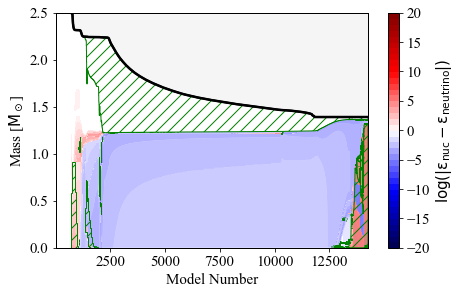

In [23]:
# Kipp diagran vs model number

mapa = 'seismic'

history = mesa_data(history_file, read_data_cols = ["star_mass", "model_number"])
max_mass = max(history.get("star_mass"))
max_model = max(history.get("model_number"))
min_model = min(history.get("model_number"))

mini, maxi = (-20,20)
step = 1
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(mini,maxi+step,step)
CS3 = plt.contourf(Z, levels, cmap=mapa)
plt.clf()
profile_paths = get_profile_paths([log_directory])
# if data is distributed among several history.data files, you can provide them
history_paths = [history_file]



# Arguments for plotter
# Mass vs model number
kipp_args = mkipp.Kipp_Args(
    logs_dirs = [log_directory],
    contour_colormap = mapa,
    xaxis = "model_number",
    function_on_xaxis = lambda x: x,
    yaxis = "mass",
    # show_conv = True, 
    # show_therm = True, 
    # show_semi = False, 
    # show_over = False, 
    # show_rot = False,
    core_masses = ["total"],
    decorate_plot = False
)



xaxis_divide = kipp_args.xaxis_divide
if kipp_args.xaxis == "star_age":
    if kipp_args.time_units == "1000 yr":
        xaxis_divide = 1000
    elif kipp_args.time_units == "Myr":
        xaxis_divide = 1e6
    elif kipp_args.time_units == "Gyr":
        xaxis_divide = 1e9
        
        
        
# Canvas
golden_ratio = (np.sqrt(5.0) - 1.0) / 2.0
fig_width = 7.0
fig_height = fig_width * golden_ratio
fontsize = 15

params = {
    'font.family': 'sans-serif',
    'font.sans-serif' : ['Times New Roman'],
    'font.size' : fontsize,
    "figure.figsize":[fig_width, fig_height],
    'axes.labelsize' : fontsize,
    'axes.titlesize' : fontsize,
    'xtick.labelsize' : fontsize,
    'ytick.labelsize' : fontsize,
    'legend.fontsize' : fontsize,
    'axes.linewidth' : 1,
    'lines.linewidth' : 2.5
}
plt.rcParams.update(params)

fig = plt.figure()
axis = plt.gca()
colormapper = plt.get_cmap(mapa)



# Plotting burning zones
xyz_data = kipp_data.get_xyz_data(profile_paths, kipp_args)
burning_zones = get_burning_zones(history_paths, kipp_args, xlims = xyz_data.xlims)
for i,zone in enumerate(burning_zones.zones):
    color = ""
    x = (float(burning_zones.burn_types[i])+20.0)/40.0
    if x>1:
        x=0.9999999999
    if x<0:
        x=0
    color = colormapper(x)

    axis.add_patch(PathPatch(zone, color=color, alpha = 0.5, lw = 0))
    
    
mixing_zones = kipp_data.get_mixing_zones(history_paths, kipp_args, xlims = xyz_data.xlims)
for i,zone in enumerate(mixing_zones.zones):
    color = ""
    # Convective mixing
    if mixing_zones.mix_types[i] == 1: #convection
        color = "green"
        hatch = "//"
        line  = 1
    # Overshooting 
    elif mixing_zones.mix_types[i] == 3: #overshooting
        color = "purple"
        hatch = "x"
        line  = 1
    # Semiconvective mixing
    # elif mixing_zones.mix_types[i] == 4: #semiconvection
        # color = '#f28123'
    # elif mixing_zones.mix_types[i] == 5: #thermohaline
        # color = '#ffc132'
    # elif mixing_zones.mix_types[i] == 6: #rotational mixing
        # color = '#087e8b'

    else:
        continue

    axis.add_patch(PathPatch(zone, fill=False, hatch = hatch, edgecolor=color, linewidth=line))
    
    
for i, x_coord in enumerate(mixing_zones.x_coords):
        if x_coord > xyz_data.xlims[1]:
            break
            
# I also fill with white above the plot to cover any remainer of the contour plot
axis.fill_between(mixing_zones.x_coords, max(mixing_zones.y_coords)+5.0, mixing_zones.y_coords, color = "whitesmoke")
axis.plot(mixing_zones.x_coords[:i], mixing_zones.y_coords[:i], "k-")

# add core masses
if kipp_args.yaxis == "mass":
    for core_mass in kipp_args.core_masses:
        if core_mass == "He":
            field_name = "he_core_mass"
            color = "b:"
        elif core_mass == "C":
            field_name = "c_core_mass"
            color = "r:"
        elif core_mass == "O":
            field_name = "o_core_mass"
            color = "g:"
        elif core_mass == "total":
            field_name = "star_mass"
            color = "k"
            line = 2
        for history in mixing_zones.histories:
            axis.plot(kipp_args.function_on_xaxis(history.get(kipp_args.xaxis) / xaxis_divide), \
                    history.get(field_name), color, linewidth=line)
    
    


# Colorbar
bar = plt.colorbar(CS3)
bar.set_label(r"$\rm \log \left( |\epsilon_{\rm nuc} - \epsilon_{neutrino}| \right)$")
axis.set_xlabel("Model Number")
axis.set_ylabel(r"Mass [$\rm M_\odot$]")

axis.set_ylim([0.0, 2.5])
axis.set_xlim([min_model, max_model])
# axis.set_ylim([0.0, 2.5])
# axis.set_xlim([10000, 15000])


# plt.axvline(11955, c='b', ls='--') # 1st Urca
# plt.axvline(12800, c='b', ls='--') # 2nd Urca
# plt.axvline(13299, c='b', ls='--') # end Urca
# plt.axvline(13300, c='b', ls='--') # Mg24 e-captures

# plt.axvline(26740, c='b', ls='--') # simmering
# plt.axvline(27075, c='b', ls='--') # carbon burning
# plt.axvline(21450, c='b', ls='--') # end carbon burning
# plt.axvline(24245, c='b', ls='--') # oxygen burning



# plt.text(21875, 2.1, text_urca, fontsize = 12, horizontalalignment='center', verticalalignment='center')
# plt.text(22235, 2.1, text_cburn, fontsize = 12, horizontalalignment='center', verticalalignment='center')
# plt.text(22565, 2.1, text_oburn, fontsize = 12, horizontalalignment='center', verticalalignment='center')

# plt.annotate("",
#             xy=(27500, 1.9),
#             xytext=(26500, 2.1),
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="arc3"),
#             )



# plt.savefig(os.path.join(plot_results_dir, 'new_kipps_net/model_number/series1_mn_2p5M_z0p02_f0.png'), dpi=300, bbox_inches='tight')


## Final fates

In [24]:
def mass_converter_he_to_zams(masses):
    
    """Relation between He-star and original star, 
    based on Woosley (2019)"""
    
    zams_mass = []
    for mass in masses:
        zams_mass.append(round((mass/0.0385)**(1/1.603),1))
    return zams_mass

def mass_converter_zams_to_he(masses):
    
    """Relation between He-star and original star, 
    based on Woosley (2019)"""
    
    helium_cores_mass = []
    for mass in masses:
        helium_cores_mass.append(round(0.0385 * mass ** 1.603, 1))
    return helium_cores_mass 



# Same functions as above
# They take (and return) a single
# value instead of a list of values

def f1(x):
    return (x/0.0385)**(1/1.603)

def f2(x):
    return 0.0385 * x ** 1.603

In [25]:
test1 = mass_converter_he_to_zams([6.0])
print(test1)
test2 = mass_converter_zams_to_he([23.3])
print(test2)


zams_masses_grid = mass_converter_he_to_zams([0.7, 0.8, 0.9, 
                                             1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
                                             2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9,
                                             3.0, 3.1, 3.2, 3.3, 3.4, 3.5])
print(zams_masses_grid)

[23.3]
[6.0]
[6.1, 6.6, 7.1, 7.6, 8.1, 8.5, 9.0, 9.4, 9.8, 10.2, 10.6, 11.0, 11.4, 11.8, 12.1, 12.5, 12.8, 13.2, 13.5, 13.8, 14.2, 14.5, 14.8, 15.1, 15.5, 15.8, 16.1, 16.4, 16.7]


<Figure size 864x533.981 with 0 Axes>

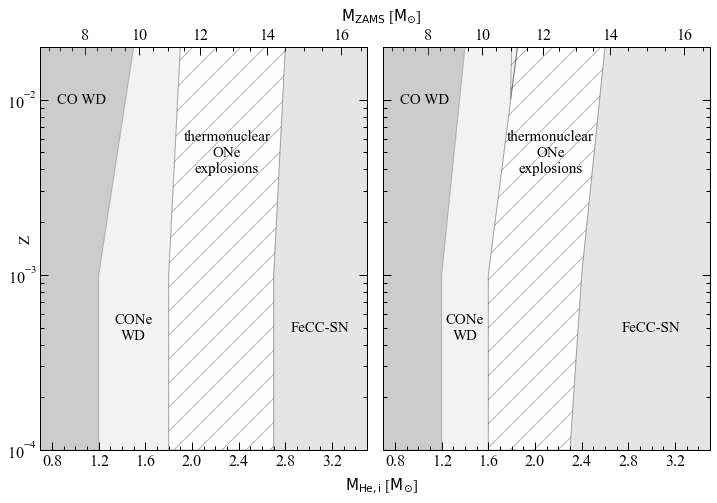

In [154]:
fontsize=16
make_canvas(fig_width=12.0, columns=1, clear=True, fontsize=fontsize)


text_cowd = 'CO WD'
text_conewd = 'CONe' + '\n' + 'WD'
text_tns = 'thermonuclear' + '\n' + 'ONe' + '\n' + 'explosions'
text_ccsn = 'FeCC-SN'



f, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True)

# Leave some whitespace between the plots
f.subplots_adjust(wspace=0.05)

# Common axes labels
f.text(0.52, 0.93, r'$\rm M_{ZAMS}$ [$\rm M_{\odot}$]', ha='center', size = 15)
f.text(0.52, 0.05, r'$\rm M_{He,i}$ [$\rm M_{\odot}$]', ha='center', size = 15)
f.text(0.1, 0.52, r'Z', va='center', rotation='vertical', size = 15)


# Left Panel
# -----------------------------------------------
ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.set_ylim([0.0001, 0.02])
ax1.set_xlim([0.7, 3.5])

ax1.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=False, right=True)
ax1.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=False, right=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_minor_locator(AutoMinorLocator())

#ax3 = ax1.twiny()


# Plot
ax1.fill([0.7, 1.2, 1.2, 1.5, 0.7, 0.7],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.4, color='gray')
ax1.fill([1.2, 1.8, 1.8, 1.9, 1.5, 1.2],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.1, color='gray')
ax1.fill([1.8, 2.7, 2.7, 2.8, 1.9, 1.8],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.3, 
         color='black', hatch='/', fill=False)
ax1.fill([2.7, 3.5, 3.5, 3.5, 2.8, 2.7],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha=0.2, color='gray')


secax1 = ax1.secondary_xaxis('top', functions=(f1, f2))
secax1.tick_params(direction='in', which='major', axis='x', length=8, width=1)
secax1.tick_params(direction='in', which='minor', axis='x', length=4, width=1)
secax1.xaxis.set_major_locator(plt.MaxNLocator(7))
secax1.xaxis.set_minor_locator(AutoMinorLocator())


# Annotation
ax1.text(1.05, 0.01, text_cowd, fontsize = 15, horizontalalignment='center', verticalalignment='center')
ax1.text(1.5, 0.0005, text_conewd, fontsize = 15, horizontalalignment='center', verticalalignment='center')
ax1.text(2.3, 0.005, text_tns, fontsize = 15, horizontalalignment='center', verticalalignment='center')
ax1.text(3.1, 0.0005, text_ccsn, fontsize = 15, horizontalalignment='center', verticalalignment='center')



# Right Panel
# ------------------------------------------------
ax2.set_yscale('log')
ax2.set_xscale('linear')
ax2.set_ylim([0.0001, 0.02])
ax2.set_xlim([0.7, 3.5])

ax2.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=False, right=True)
ax2.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=False, right=True)
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.xaxis.set_minor_locator(AutoMinorLocator())

# Plot
ax2.fill([0.7, 1.2, 1.2, 1.4, 0.7, 0.7],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.4, color='gray')
ax2.fill([1.2, 1.6, 1.6, 1.85, 1.4, 1.2],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.1, color='gray')
ax2.fill([1.6, 2.3, 2.4, 2.6, 1.85, 1.6],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha = 0.3, 
         color='black', hatch='/', fill=False)
ax2.fill([2.3, 3.5, 3.5, 3.5, 2.6, 2.4],[0.0001, 0.0001, 0.001, 0.02, 0.02, 0.001], alpha=0.2, color='gray')
ax2.fill([1.79, 1.85, 1.8],[0.01, 0.02, 0.02], hatch='/', fill=False, color='black', alpha=0.3)

secax2 = ax2.secondary_xaxis('top', functions=(f1, f2))
secax2.tick_params(direction='in', which='major', axis='x', length=8, width=1)
secax2.tick_params(direction='in', which='minor', axis='x', length=4, width=1)
secax2.xaxis.set_major_locator(plt.MaxNLocator(7))
secax2.xaxis.set_minor_locator(AutoMinorLocator())

# Annotation
ax2.text(1.05, 0.01, text_cowd, fontsize = 15, horizontalalignment='center', verticalalignment='center')
ax2.text(1.4, 0.0005, text_conewd, fontsize = 15, horizontalalignment='center', verticalalignment='center')
ax2.text(2.135, 0.005, text_tns, fontsize = 15, horizontalalignment='center', verticalalignment='center')
ax2.text(3.0, 0.0005, text_ccsn, fontsize = 15, horizontalalignment='center', verticalalignment='center')


# plt.savefig(os.path.join(plot_results_dir, 'final_fates_graph_with_zams.pdf'), bbox_inches='tight', dpi=300)

In [29]:
x = np.linspace(0.0, 27.0, 28)
y = np.linspace(0.0, 2, 3)

XLOW,YLOW = np.meshgrid(x,y)
XINTER,YINTER = np.meshgrid(x,y)
XHIGH, YHIGH = np.meshgrid(x,y)

In [30]:
# Ain't nobody got time to think of
# unique and meaninfgul function names 

def function(X1,Y1, X2,Y2, X3,Y3):
    
    m1,z1,f1,c1,e1,r1 = [],[],[],[],[],[]
    ZLOW = np.zeros((3, 28))
    ZINTER = np.zeros((3, 28))
    ZHIGH = np.zeros((3, 28))
    
    # Read data from file
    with open('/Users/schanlar/Desktop/fullCoreGrowthData.csv', 'r') as file:
        next(file)
        reader = csv.reader(file)
        
        for row in reader:
            m1.append(row[0])
            z1.append(row[1])
            f1.append(row[2])
            c1.append(float(row[3]))
            e1.append(float(row[4]))
            r1.append(row[5])
            
            
            
    for i,j,k in list(zip(X1,Y1,ZLOW)):
        
        for idx, value in enumerate(j):
    
            if math.isclose(value,0.0):
                metallicity = '0.0001'
                overshooting = '0.0000'

            elif math.isclose(value,1.0):
                metallicity = '0.0001'
                overshooting = '0.0140'

            elif math.isclose(value,2.0):
                metallicity = '0.0001'
                overshooting = '0.0160'
                
                
            if math.isclose(i[idx], 0.0):
                mass = '0.8000'

            elif math.isclose(i[idx], 1.0):
                mass = '0.9000'

            elif math.isclose(i[idx], 2.0):
                mass = '1.0000'

            elif math.isclose(i[idx], 3.0):
                mass = '1.1000'

            elif math.isclose(i[idx], 4.0):
                mass = '1.2000'

            elif math.isclose(i[idx], 5.0):
                mass = '1.3000'

            elif math.isclose(i[idx], 6.0):
                mass = '1.4000'

            elif math.isclose(i[idx], 7.0):
                mass = '1.5000'

            elif math.isclose(i[idx], 8.0):
                mass = '1.6000'

            elif math.isclose(i[idx], 9.0):
                mass = '1.7000'

            elif math.isclose(i[idx], 10.0):
                mass = '1.8000'

            elif math.isclose(i[idx], 11.0):
                mass = '1.9000'

            elif math.isclose(i[idx], 12.0):
                mass = '2.0000'

            elif math.isclose(i[idx], 13.0):
                mass = '2.1000'

            elif math.isclose(i[idx], 14.0):
                mass = '2.2000'

            elif math.isclose(i[idx], 15.0):
                mass = '2.3000'

            elif math.isclose(i[idx], 16.0):
                mass = '2.4000'

            elif math.isclose(i[idx], 17.0):
                mass = '2.5000'

            elif math.isclose(i[idx], 18.0):
                mass = '2.6000'

            elif math.isclose(i[idx], 19.0):
                mass = '2.7000'

            elif math.isclose(i[idx], 20.0):
                mass = '2.8000'

            elif math.isclose(i[idx], 21.0):
                mass = '2.9000'

            elif math.isclose(i[idx], 22.0):
                mass = '3.0000'

            elif math.isclose(i[idx], 23.0):
                mass = '3.1000'

            elif math.isclose(i[idx], 24.0):
                mass = '3.2000'

            elif math.isclose(i[idx], 25.0):
                mass = '3.3000'

            elif math.isclose(i[idx], 26.0):
                mass = '3.4000'

            elif math.isclose(i[idx], 27.0):
                mass = '3.5000'
                
                
            for a1,a2,a3,a4,a5,a6 in zip(m1,z1,f1,c1,e1,r1):

                if a1 == mass and a2 == metallicity and a3 == overshooting:
                    
                    if a5 <= 0.2:
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        #elif math.isclose(a4, 1.35, rel_tol = 0.02):
                            #k[idx] = 6
                            
                        elif (a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        elif (a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif (a6 == 'COWD' or a6 == 'COWD*' or a6 == 'COWD**'):
                            k[idx] = 1
                            
                        elif (a6 == 'CONeWD' or a6 == 'CONeWD*' or a6 == 'CONeWD**' or a6 == 'CONewD'):
                            k[idx] = 2
                            
                        elif (a6 == 'ONeWD' or a6 == 'ONeWD*' or a6 == 'ONeWD**'):
                            k[idx] = 3
                            
                        else:
                            k[idx] = 0
                            
                    else:
                        
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        elif a4 < 1.45 and a4 > 1.37 and (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif a4 < 1.45 and (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        else:
                            k[idx] = 0
                            
                        
        

        

    for i,j,k in list(zip(X2,Y2,ZINTER)):
        
        for idx, value in enumerate(j):
    
            if math.isclose(value,0.0):
                metallicity = '0.0010'
                overshooting = '0.0000'

            elif math.isclose(value,1.0):
                metallicity = '0.0010'
                overshooting = '0.0140'

            elif math.isclose(value,2.0):
                metallicity = '0.0010'
                overshooting = '0.0160'
                
                
            if math.isclose(i[idx], 0.0):
                mass = '0.8000'

            elif math.isclose(i[idx], 1.0):
                mass = '0.9000'

            elif math.isclose(i[idx], 2.0):
                mass = '1.0000'

            elif math.isclose(i[idx], 3.0):
                mass = '1.1000'

            elif math.isclose(i[idx], 4.0):
                mass = '1.2000'

            elif math.isclose(i[idx], 5.0):
                mass = '1.3000'

            elif math.isclose(i[idx], 6.0):
                mass = '1.4000'

            elif math.isclose(i[idx], 7.0):
                mass = '1.5000'

            elif math.isclose(i[idx], 8.0):
                mass = '1.6000'

            elif math.isclose(i[idx], 9.0):
                mass = '1.7000'

            elif math.isclose(i[idx], 10.0):
                mass = '1.8000'

            elif math.isclose(i[idx], 11.0):
                mass = '1.9000'

            elif math.isclose(i[idx], 12.0):
                mass = '2.0000'

            elif math.isclose(i[idx], 13.0):
                mass = '2.1000'

            elif math.isclose(i[idx], 14.0):
                mass = '2.2000'

            elif math.isclose(i[idx], 15.0):
                mass = '2.3000'

            elif math.isclose(i[idx], 16.0):
                mass = '2.4000'

            elif math.isclose(i[idx], 17.0):
                mass = '2.5000'

            elif math.isclose(i[idx], 18.0):
                mass = '2.6000'

            elif math.isclose(i[idx], 19.0):
                mass = '2.7000'

            elif math.isclose(i[idx], 20.0):
                mass = '2.8000'

            elif math.isclose(i[idx], 21.0):
                mass = '2.9000'

            elif math.isclose(i[idx], 22.0):
                mass = '3.0000'

            elif math.isclose(i[idx], 23.0):
                mass = '3.1000'

            elif math.isclose(i[idx], 24.0):
                mass = '3.2000'

            elif math.isclose(i[idx], 25.0):
                mass = '3.3000'

            elif math.isclose(i[idx], 26.0):
                mass = '3.4000'

            elif math.isclose(i[idx], 27.0):
                mass = '3.5000'
                
                
            for a1,a2,a3,a4,a5,a6 in zip(m1,z1,f1,c1,e1,r1):

                if a1 == mass and a2 == metallicity and a3 == overshooting:
                    
                    if a5 <= 0.2:
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        #elif math.isclose(a4, 1.35, rel_tol = 0.02):
                        #    k[idx] = 6
                            
                        elif (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        elif (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif (a6 == 'COWD' or a6 == 'COWD*' or a6 == 'COWD**'):
                            k[idx] = 1
                            
                        elif (
                            a6 == 'CONeWD' or a6 == 'CONeWD*' or a6 == 'CONeWD**' or a6 == 'CONewD'):
                            k[idx] = 2
                            
                        elif (a6 == 'ONeWD' or a6 == 'ONeWD*' or a6 == 'ONeWD**'):
                            k[idx] = 3
                            
                        else:
                            k[idx] = 0
                            
                    else:
                        
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        elif a4 < 1.45 and a4 > 1.37 and (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif a4 < 1.45 and (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        else:
                            k[idx] = 0
                            
                            
                            
                            
                            
    for i,j,k in list(zip(X3,Y3,ZHIGH)):
        
        for idx, value in enumerate(j):
    
            if math.isclose(value,0.0):
                metallicity = '0.0200'
                overshooting = '0.0000'

            elif math.isclose(value,1.0):
                metallicity = '0.0200'
                overshooting = '0.0140'

            elif math.isclose(value,2.0):
                metallicity = '0.0200'
                overshooting = '0.0160'
                
                
            if math.isclose(i[idx], 0.0):
                mass = '0.8000'

            elif math.isclose(i[idx], 1.0):
                mass = '0.9000'

            elif math.isclose(i[idx], 2.0):
                mass = '1.0000'

            elif math.isclose(i[idx], 3.0):
                mass = '1.1000'

            elif math.isclose(i[idx], 4.0):
                mass = '1.2000'

            elif math.isclose(i[idx], 5.0):
                mass = '1.3000'

            elif math.isclose(i[idx], 6.0):
                mass = '1.4000'

            elif math.isclose(i[idx], 7.0):
                mass = '1.5000'

            elif math.isclose(i[idx], 8.0):
                mass = '1.6000'

            elif math.isclose(i[idx], 9.0):
                mass = '1.7000'

            elif math.isclose(i[idx], 10.0):
                mass = '1.8000'

            elif math.isclose(i[idx], 11.0):
                mass = '1.9000'

            elif math.isclose(i[idx], 12.0):
                mass = '2.0000'

            elif math.isclose(i[idx], 13.0):
                mass = '2.1000'

            elif math.isclose(i[idx], 14.0):
                mass = '2.2000'

            elif math.isclose(i[idx], 15.0):
                mass = '2.3000'

            elif math.isclose(i[idx], 16.0):
                mass = '2.4000'

            elif math.isclose(i[idx], 17.0):
                mass = '2.5000'

            elif math.isclose(i[idx], 18.0):
                mass = '2.6000'

            elif math.isclose(i[idx], 19.0):
                mass = '2.7000'

            elif math.isclose(i[idx], 20.0):
                mass = '2.8000'

            elif math.isclose(i[idx], 21.0):
                mass = '2.9000'

            elif math.isclose(i[idx], 22.0):
                mass = '3.0000'

            elif math.isclose(i[idx], 23.0):
                mass = '3.1000'

            elif math.isclose(i[idx], 24.0):
                mass = '3.2000'

            elif math.isclose(i[idx], 25.0):
                mass = '3.3000'

            elif math.isclose(i[idx], 26.0):
                mass = '3.4000'

            elif math.isclose(i[idx], 27.0):
                mass = '3.5000'
                
                
            for a1,a2,a3,a4,a5,a6 in zip(m1,z1,f1,c1,e1,r1):

                if a1 == mass and a2 == metallicity and a3 == overshooting:
                    
                    if a5 <= 0.2:
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        #elif math.isclose(a4, 1.35, rel_tol = 0.02):
                        #    k[idx] = 6
                            
                        elif (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        elif (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif (a6 == 'COWD' or a6 == 'COWD*' or a6 == 'COWD**'):
                            k[idx] = 1
                            
                        elif (
                            a6 == 'CONeWD' or a6 == 'CONeWD*' or a6 == 'CONeWD**' or a6 == 'CONewD'):
                            k[idx] = 2
                            
                        elif (a6 == 'ONeWD' or a6 == 'ONeWD*' or a6 == 'ONeWD**'):
                            k[idx] = 3
                            
                        else:
                            k[idx] = 0
                            
                    else:
                        
                        if a4 >= 1.45:
                            k[idx] = 5
                            
                        elif a4 < 1.45 and a4 > 1.37 and (
                            a6 == 'SiCORE' or a6 == 'SiCORE*' or a6 == 'SiCORE**'):
                            k[idx] = 5
                            
                        elif a4 < 1.45 and (
                            a6 == 'ONeSiWD' or a6 == 'ONeSiWD*' or a6 == 'ONeSiWD**'):
                            k[idx] = 4
                            
                        else:
                            k[idx] = 0
                            
                            
    return ZLOW, ZINTER, ZHIGH

In [31]:
ZLOW, ZINTER, ZHIGH = function(XLOW,YLOW, XINTER, YINTER, XHIGH, YHIGH)

<ipython-input-179-91a8190d58b6>:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xlabels, minor=True)
<ipython-input-179-91a8190d58b6>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(y1labels, minor=True, size=14)
<ipython-input-179-91a8190d58b6>:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(y1labels, minor=True, size=14)
<ipython-input-179-91a8190d58b6>:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(y1labels, minor=True, size=14)
<ipython-input-179-91a8190d58b6>:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(['N/A','CO', 'CONe', 'ONe', 'ONeSi', 'Si'], size = 14)


<Figure size 864x533.981 with 0 Axes>

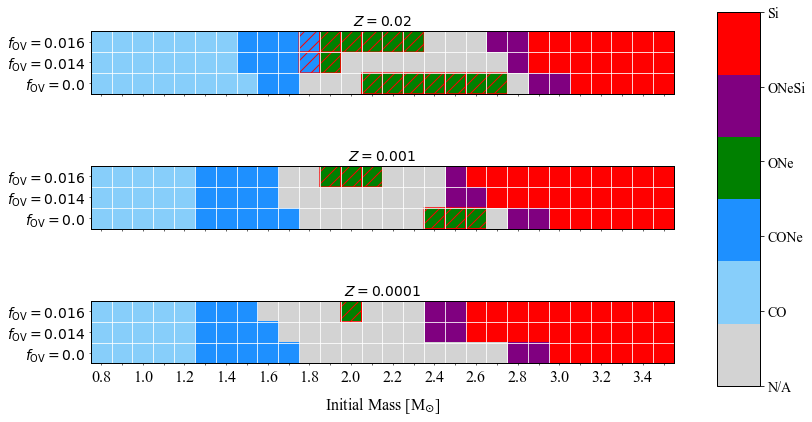

In [179]:
myCmap = cmap(['lightgray', 'lightskyblue', 'dodgerblue', 'green', 'purple', 'red'])

fontsize=16
make_canvas(fig_width=12.0, columns=1, clear=True, fontsize=fontsize)




fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex='all', sharey='all')

fig.subplots_adjust(hspace=0.01)

img3 = ax3.imshow(ZLOW, cmap = myCmap, interpolation = 'none', origin = 'lower')
img2 = ax2.imshow(ZINTER, cmap = myCmap, interpolation = 'none', origin = 'lower')
img1 = ax1.imshow(ZHIGH, cmap = myCmap, interpolation = 'none', origin = 'lower')
#ax1.add_patch(matplotlib.patches.Rectangle((8.5, 0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'k'))
ax1.add_patch(matplotlib.patches.Rectangle((9.5, 0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((10.5, 0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
#ax1.add_patch(matplotlib.patches.Rectangle((8.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'k'))
ax1.add_patch(matplotlib.patches.Rectangle((9.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((10.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((11.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((12.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((13.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((14.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((12.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((13.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((14.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((15.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((16.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((17.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax1.add_patch(matplotlib.patches.Rectangle((18.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))

ax2.add_patch(matplotlib.patches.Rectangle((10.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax2.add_patch(matplotlib.patches.Rectangle((11.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax2.add_patch(matplotlib.patches.Rectangle((12.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax2.add_patch(matplotlib.patches.Rectangle((15.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax2.add_patch(matplotlib.patches.Rectangle((16.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))
ax2.add_patch(matplotlib.patches.Rectangle((17.5, -0.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))

ax3.add_patch(matplotlib.patches.Rectangle((11.5, 1.5), 1, 1, hatch = '//', fill = False, snap = False, color = 'r'))

# These are actually ONe WDs
ax2.add_patch(matplotlib.patches.Rectangle((5.5, -0.5), 1, 1, fill = True, color = 'dodgerblue'))
ax3.add_patch(matplotlib.patches.Rectangle((6.5, 1.5), 1, 1, fill = True, color = 'dodgerblue'))




ax1.grid(True, which = 'major', axis = 'both', color = 'white')
ax2.grid(True, which = 'major', axis = 'both', color = 'white')
ax3.grid(True, which = 'major', axis = 'both', color = 'white')

ax1.xaxis.set_minor_locator(plt.MaxNLocator(29))
ax1.yaxis.set_minor_locator(plt.MaxNLocator(3))
ax2.yaxis.set_minor_locator(plt.MaxNLocator(3))
ax3.yaxis.set_minor_locator(plt.MaxNLocator(3))

ax1.tick_params(axis = 'both', which = 'major', length=0)
ax2.tick_params(axis = 'both', which = 'major', length=0)
ax3.tick_params(axis = 'both', which = 'major', length=0)

# Shift grid by 0.5 in both directions
ax1.set_xticks(np.arange(-.5, 27, 1))
ax1.set_yticks(np.arange(-.5, 3, 1))

ax2.set_xticks(np.arange(-.5, 27, 1))
ax2.set_yticks(np.arange(-.5, 3, 1))

ax3.set_xticks(np.arange(-.5, 27, 1))
ax3.set_yticks(np.arange(-.5, 3, 1))

# Get labels
xlabels = [item.get_text() for item in ax3.get_xticklabels(minor = True)]
y1labels = [item.get_text() for item in ax1.get_yticklabels(minor = True)]
y2labels = [item.get_text() for item in ax2.get_yticklabels(minor = True)]
y3labels = [item.get_text() for item in ax3.get_yticklabels(minor = True)]

# Create custom labels
xlabels[1] = '0.8'
#xlabels[2] = '0.9'
xlabels[3] = '1.0'
#xlabels[4] = '1.1'
xlabels[5] = '1.2'
#xlabels[6] = '1.3'
xlabels[7] = '1.4'
#xlabels[8] = '1.5'
xlabels[9] = '1.6'
#xlabels[10] = '1.7'
xlabels[11] = '1.8'
xlabels[13] = '2.0'
xlabels[15] = '2.2'
xlabels[17] = '2.4'
xlabels[19] = '2.6'
xlabels[21] = '2.8'
xlabels[23] = '3.0'
xlabels[25] = '3.2'
xlabels[27] = '3.4'

y1labels[1] = r'$f_{\rm OV}=0.0$'
y1labels[2] = r'$f_{\rm OV}=0.014$'
y1labels[3] = r'$f_{\rm OV}=0.016$'

# Set new labels
ax3.set_xticklabels(xlabels, minor=True)
ax3.set_xticklabels([])
ax3.set_xlabel(r'Initial Mass [M$_{\odot}$]', labelpad=10)

ax1.set_yticklabels(y1labels, minor=True, size=14)
ax2.set_yticklabels(y1labels, minor=True, size=14)
ax3.set_yticklabels(y1labels, minor=True, size=14)
ax1.set_yticklabels([])

ax1.set_title(r'$Z=0.02$', size=14)
ax2.set_title(r'$Z=0.001$', size=14)
ax3.set_title(r'$Z=0.0001$', size=14)


# Colorbar config
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.2)

#cbar = plt.colorbar(img, cmap = myCmap, cax = cax)
#cbar.ax.set_yticklabels(['N/A','COWD', 'CONeWD', 'ONeWD', 'ONeSiWD', 'CCSN', 'TNE'], size = 13)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img1, cax=cbar_ax)
cbar_ax.set_yticklabels(['N/A','CO', 'CONe', 'ONe', 'ONeSi', 'Si'], size = 14)

# plt.savefig(os.path.join(plot_results_dir, 'parameterSpaceRaster.png'), dpi=300, bbox_inches='tight')

## SNe rates

In [34]:
# SNIa (f_OV = 0.0)
zams_zsol = mass_converter_he_to_zams([2.1, 2.7])
zams_zlow = mass_converter_he_to_zams([1.8, 2.6])
print('Integral boundaries: ', zams_zsol, zams_zlow)

I1 = quad(lambda m: m**(-2.35), zams_zsol[0], zams_zsol[1])
I2 = quad(lambda m: m**(-2.35), zams_zlow[0], zams_zlow[1])

print(r'Ratio SNIa (f_{OV} = 0.0): ', I1[0]/I2[0])

# SNIa (f_OV = 0.016)
zams_zsol = mass_converter_he_to_zams([1.8, 2.6])
zams_zlow = mass_converter_he_to_zams([1.7, 2.3])
print('Integral boundaries: ', zams_zsol, zams_zlow)

I1 = quad(lambda m: m**(-2.35), zams_zsol[0], zams_zsol[1])
I2 = quad(lambda m: m**(-2.35), zams_zlow[0], zams_zlow[1])

print(r'Ratio SNIa (f_{OV} = 0.016): ', I1[0]/I2[0])


# CCSN (f_OV = 0.0)
zams_zsol = mass_converter_he_to_zams([2.8, 40.0])
zams_zlow = mass_converter_he_to_zams([2.7, 25.0])
print('Integral boundaries: ', zams_zsol, zams_zlow)

I1 = quad(lambda m: m**(-2.35), zams_zsol[0], zams_zsol[1])
I2 = quad(lambda m: m**(-2.35), zams_zlow[0], zams_zlow[1])

print(r'Ratio CCSN (f_{OV} = 0.0): ', I1[0]/I2[0])

# CCSN (f_OV = 0.016)
zams_zsol = mass_converter_he_to_zams([2.7, 40.0])
zams_zlow = mass_converter_he_to_zams([2.4, 30.0])
print('Integral boundaries: ', zams_zsol, zams_zlow)

I1 = quad(lambda m: m**(-2.35), zams_zsol[0], zams_zsol[1])
I2 = quad(lambda m: m**(-2.35), zams_zlow[0], zams_zlow[1])

print(r'Ratio CCSN (f_{OV} = 0.016): ', I1[0]/I2[0])

Integral boundaries:  [12.1, 14.2] [11.0, 13.8]
Ratio SNIa (f_{OV} = 0.0):  0.6478291146030417
Integral boundaries:  [11.0, 13.8] [10.6, 12.8]
Ratio SNIa (f_{OV} = 0.016):  1.1160475288666674
Integral boundaries:  [14.5, 76.2] [14.2, 56.8]
Ratio CCSN (f_{OV} = 0.0):  1.0266648223059232
Integral boundaries:  [14.2, 76.2] [13.2, 63.7]
Ratio CCSN (f_{OV} = 0.016):  0.9225305380153256


## Core growth

In [40]:
# Read, parse, and sort the data according to metallicity and overshooting factor

mass,metal,fover,mcore,menv,ffate = [],[],[],[],[],[]

massLM_WNO, massIM_WNO, massSM_WNO = [], [], []
massLM_WO1, massIM_WO1, massSM_WO1 = [], [], []
massLM_WO2, massIM_WO2, massSM_WO2 = [], [], []

coreMassLM_WNO, coreMassIM_WNO, coreMassSM_WNO = [], [], []
coreMassLM_WO1, coreMassIM_WO1, coreMassSM_WO1 = [], [], []
coreMassLM_WO2, coreMassIM_WO2, coreMassSM_WO2 = [], [], []

envMassLM_WNO, envMassIM_WNO, envMassSM_WNO = [], [], []
envMassLM_WO1, envMassIM_WO1, envMassSM_WO1 = [], [], []
envMassLM_WO2, envMassIM_WO2, envMassSM_WO2 = [], [], []

with open('/Users/schanlar/Desktop/fullCoreGrowthData.csv', 'r') as f:
    # Skip header of first row
    next(f)
    r = csv.reader(f)
    for row in r:
        mass.append(row[0])
        metal.append(row[1])
        fover.append(row[2])
        mcore.append(row[3])
        menv.append(row[4])
        ffate.append(row[5])
        
for i,j,k,l,m,n in list(zip(mass, metal, fover, mcore, menv, ffate)):
    
        # Consider only data than retain an envelope mass < 0.2 Msol, 
        # or their core mass exceed the Chandrasekhar mass limit, 
        # or they've formed a silicon core/shell at the time they
        # were terminated. In the latter case, we assume these models
        # will eventually grow to Chandra limit and experience a CCSN
        if float(m) <= 0.2 or float(l) >= 1.45 or n == 'SiCORE' or n == 'SiCORE*' or n == 'SiCORE**'or \
                n == 'ONeSiWD' or n == 'ONeSiWD*' or n == 'ONeSiWD**':
            
            if j == '0.0001' and k == '0.0000':
                massLM_WNO.append(float(i))
                coreMassLM_WNO.append(float(l))
                envMassLM_WNO.append(float(m))

            elif j == '0.0010' and k == '0.0000':
                massIM_WNO.append(float(i))
                coreMassIM_WNO.append(float(l))
                envMassIM_WNO.append(float(m))

            elif j == '0.0200' and k == '0.0000':
                massSM_WNO.append(float(i))
                coreMassSM_WNO.append(float(l))
                envMassSM_WNO.append(float(m))

            elif j == '0.0001' and k == '0.0140':
                massLM_WO1.append(float(i))
                coreMassLM_WO1.append(float(l))
                envMassLM_WO1.append(float(m))

            elif j == '0.0010' and k == '0.0140':
                massIM_WO1.append(float(i))
                coreMassIM_WO1.append(float(l))
                envMassIM_WO1.append(float(m))

            elif j == '0.0200' and k == '0.0140':
                massSM_WO1.append(float(i))
                coreMassSM_WO1.append(float(l))
                envMassSM_WO1.append(float(m))

            elif j == '0.0001' and k == '0.0160':
                massLM_WO2.append(float(i))
                coreMassLM_WO2.append(float(l))
                envMassLM_WO2.append(float(m))

            elif j == '0.0010' and k == '0.0160':
                massIM_WO2.append(float(i))
                coreMassIM_WO2.append(float(l))
                envMassIM_WO2.append(float(m))

            elif j == '0.0200' and k == '0.0160':
                massSM_WO2.append(float(i))
                coreMassSM_WO2.append(float(l))
                envMassSM_WO2.append(float(m))

<Figure size 720x1080 with 0 Axes>

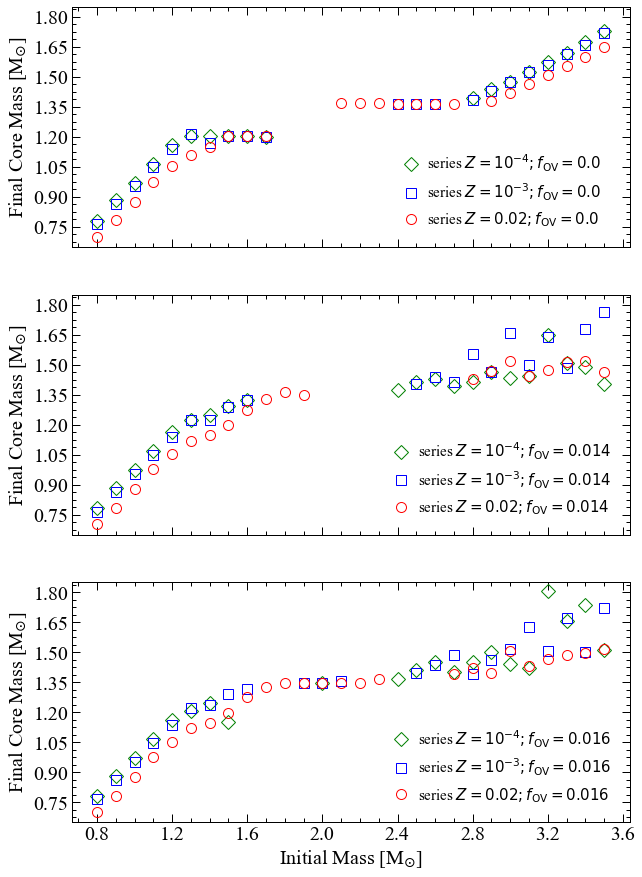

In [73]:
# Plot
# -------------------------------------------------------------
make_canvas(fig_width=10, fig_height=15, clear=True, fontsize=20)
s=10

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True)
ax0.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax1.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax2.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax2.set_xlabel(r'Initial Mass [M$_{\odot}$]')

ax0.set_ylim([0.65, 1.85])
ax1.set_ylim([0.65, 1.85])
ax2.set_ylim([0.65, 1.85])

ax0.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax0.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax0.xaxis.set_major_locator(plt.MaxNLocator(8))
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_major_locator(plt.MaxNLocator(8))
ax0.yaxis.set_minor_locator(AutoMinorLocator())

plot_lines = []
l1, = ax0.plot(massLM_WNO, coreMassLM_WNO, fillstyle='none', markeredgecolor = 'g', marker = 'D', 
           markersize = s, ls='')
l2, = ax0.plot(massIM_WNO, coreMassIM_WNO, fillstyle = 'none', markeredgecolor = 'b', marker = 's', 
           markersize = s, ls='')
l3, = ax0.plot(massSM_WNO, coreMassSM_WNO, fillstyle = 'none', markeredgecolor = 'r', marker = 'o', 
           markersize = s, ls='')

plot_lines.append([l1,l2,l3])
ax0.legend(plot_lines[0], 
           [r'series $Z = 10^{-4}; f_{\rm OV} = 0.0$', r'series $Z = 10^{-3}; f_{\rm OV} = 0.0$', r'series $Z = 0.02; f_{\rm OV} = 0.0$'],
          loc='upper center', frameon=False, bbox_to_anchor=(0.765, 0.45), handletextpad=0.1, prop={'size':15})



ax1.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax1.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(plt.MaxNLocator(8))
ax1.yaxis.set_minor_locator(AutoMinorLocator())

l1, = ax1.plot(massLM_WO1, coreMassLM_WO1, fillstyle = 'none', markeredgecolor = 'g', marker = 'D', 
           markersize = s, ls='')
l2, = ax1.plot(massIM_WO1, coreMassIM_WO1, fillstyle = 'none', markeredgecolor = 'b', marker = 's', 
           markersize = s, ls='')
l3, = ax1.plot(massSM_WO1, coreMassSM_WO1, fillstyle = 'none', markeredgecolor = 'r', marker = 'o', 
           markersize = s, ls='')


plot_lines.append([l1,l2,l3])

leg2 = Legend(ax1, plot_lines[1],
              [r'series $Z = 10^{-4}; f_{\rm OV} = 0.014$', r'series $Z = 10^{-3}; f_{\rm OV} = 0.014$', r'series $Z = 0.02; f_{\rm OV} = 0.014$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.765, 0.45), handletextpad=0.1, prop={'size':15})
ax1.add_artist(leg2)






ax2.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax2.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(plt.MaxNLocator(8))
ax2.yaxis.set_minor_locator(AutoMinorLocator())

l1, = ax2.plot(massLM_WO2, coreMassLM_WO2, fillstyle = 'none', markeredgecolor = 'g', marker = 'D', 
           markersize = s, ls='')
l2, = ax2.plot(massIM_WO2, coreMassIM_WO2, fillstyle = 'none', markeredgecolor = 'b', marker = 's', 
           markersize = s, ls='')
l3, = ax2.plot(massSM_WO2, coreMassSM_WO2, fillstyle = 'none', markeredgecolor = 'r', marker = 'o', 
           markersize = s, ls='')


plot_lines.append([l1,l2,l3])

leg3 = Legend(ax2, plot_lines[1],
              [r'series $Z = 10^{-4}; f_{\rm OV} = 0.016$', r'series $Z = 10^{-3}; f_{\rm OV} = 0.016$', r'series $Z = 0.02; f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.765, 0.45), handletextpad=0.1, prop={'size':15})
ax2.add_artist(leg3)


# plt.savefig(os.path.join(plot_results_dir, 'series1_coreGrowth_panel1.pdf'), dpi=300, bbox_inches='tight')


<Figure size 720x1080 with 0 Axes>

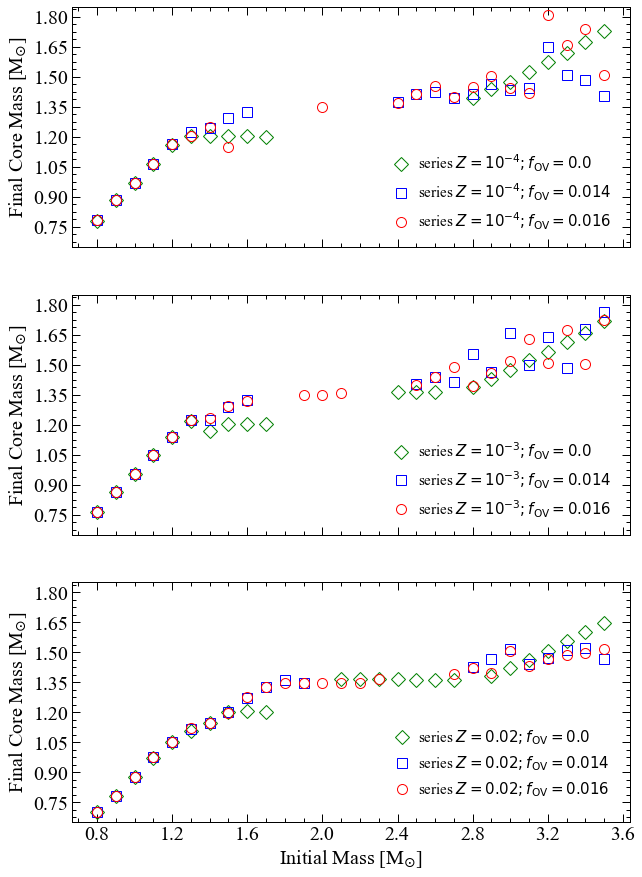

In [76]:
# Plot
# -------------------------------------------------------------
make_canvas(fig_width=10, fig_height=15, clear=True, fontsize=20)
s=10

fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True)
ax0.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax1.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax2.set_ylabel(r'Final Core Mass [M$_{\odot}$]')
ax2.set_xlabel(r'Initial Mass [M$_{\odot}$]')

ax0.set_ylim([0.65, 1.85])
ax1.set_ylim([0.65, 1.85])
ax2.set_ylim([0.65, 1.85])

ax0.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax0.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax0.xaxis.set_major_locator(plt.MaxNLocator(8))
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_major_locator(plt.MaxNLocator(8))
ax0.yaxis.set_minor_locator(AutoMinorLocator())

plot_lines = []
l1, = ax0.plot(massLM_WNO, coreMassLM_WNO, fillstyle='none', markeredgecolor = 'g', marker = 'D', 
           markersize = s, ls='')
l2, = ax0.plot(massLM_WO1, coreMassLM_WO1, fillstyle = 'none', markeredgecolor = 'b', marker = 's', 
           markersize = s, ls='')
l3, = ax0.plot(massLM_WO2, coreMassLM_WO2, fillstyle = 'none', markeredgecolor = 'r', marker = 'o', 
           markersize = s, ls='')

plot_lines.append([l1,l2,l3])
ax0.legend(plot_lines[0], 
           [r'series $Z = 10^{-4}; f_{\rm OV} = 0.0$', r'series $Z = 10^{-4}; f_{\rm OV} = 0.014$', r'series $Z = 10^{-4}; f_{\rm OV} = 0.016$'],
          loc='upper center', frameon=False, bbox_to_anchor=(0.765, 0.45), handletextpad=0.1, prop={'size':15})



ax1.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax1.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(plt.MaxNLocator(8))
ax1.yaxis.set_minor_locator(AutoMinorLocator())

l1, = ax1.plot(massIM_WNO, coreMassIM_WNO, fillstyle = 'none', markeredgecolor = 'g', marker = 'D', 
           markersize = s, ls='')
l2, = ax1.plot(massIM_WO1, coreMassIM_WO1, fillstyle = 'none', markeredgecolor = 'b', marker = 's', 
           markersize = s, ls='')
l3, = ax1.plot(massIM_WO2, coreMassIM_WO2, fillstyle = 'none', markeredgecolor = 'r', marker = 'o', 
           markersize = s, ls='')


plot_lines.append([l1,l2,l3])

leg2 = Legend(ax1, plot_lines[1],
              [r'series $Z = 10^{-3}; f_{\rm OV} = 0.0$', r'series $Z = 10^{-3}; f_{\rm OV} = 0.014$', r'series $Z = 10^{-3}; f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.765, 0.45), handletextpad=0.1, prop={'size':15})
ax1.add_artist(leg2)






ax2.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax2.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(plt.MaxNLocator(8))
ax2.yaxis.set_minor_locator(AutoMinorLocator())

l1, = ax2.plot(massSM_WNO, coreMassSM_WNO, fillstyle = 'none', markeredgecolor = 'g', marker = 'D', 
           markersize = s, ls='')
l2, = ax2.plot(massSM_WO1, coreMassSM_WO1, fillstyle = 'none', markeredgecolor = 'b', marker = 's', 
           markersize = s, ls='')
l3, = ax2.plot(massSM_WO2, coreMassSM_WO2, fillstyle = 'none', markeredgecolor = 'r', marker = 'o', 
           markersize = s, ls='')


plot_lines.append([l1,l2,l3])

leg3 = Legend(ax2, plot_lines[1],
              [r'series $Z = 0.02; f_{\rm OV} = 0.0$', r'series $Z = 0.02; f_{\rm OV} = 0.014$', r'series $Z = 0.02; f_{\rm OV} = 0.016$'],
             loc='upper center', frameon=False, bbox_to_anchor=(0.765, 0.45), handletextpad=0.1, prop={'size':15})
ax2.add_artist(leg3)


# plt.savefig(os.path.join(plot_results_dir, 'series1_coreGrowth_panel2.pdf'), dpi=300, bbox_inches='tight')

In [77]:
mass,metal,etawind,mcore,menv = [],[],[],[],[]

init_mass_eta0p1, init_mass_eta0p25, init_mass_eta0p5, init_mass_eta0p8, \
init_mass_eta1p0, init_mass_eta1p58 = [],[],[],[],[],[]

final_core_mass_eta0p1, final_core_mass_eta0p25, final_core_mass_eta0p5, \
final_core_mass_eta0p8, final_core_mass_eta1p0, final_core_mass_eta1p58 = [],[],[],[],[],[]

envelope_mass_eta0p1, envelope_mass_eta0p25, envelope_mass_eta0p5, \
envelope_mass_eta0p8, envelope_mass_eta1p0, envelope_mass_eta1p58 = [],[],[],[],[],[]

os.chdir('/Users/schanlar/Desktop')
with open('AUThCoreGrowthData.csv', 'r') as f:
    # Skip header of first row
    next(f)
    r = csv.reader(f)
    for row in r:
        mass.append(row[0])
        metal.append(row[1])
        etawind.append(row[2])
        mcore.append(row[3])
        menv.append(row[4])
        

for i,j,k,l,m in list(zip(mass, metal, etawind, mcore, menv)):
    if float(k) == 0.1000:
        init_mass_eta0p1.append(float(i))
        final_core_mass_eta0p1.append(float(l))
        envelope_mass_eta0p1.append(float(m))
    elif float(k) == 0.2500:
        init_mass_eta0p25.append(float(i))
        final_core_mass_eta0p25.append(float(l))
        envelope_mass_eta0p25.append(float(m))
    elif float(k) == 0.5000:
        init_mass_eta0p5.append(float(i))
        final_core_mass_eta0p5.append(float(l))
        envelope_mass_eta0p5.append(float(m))
    elif float(k) == 0.8000:
        init_mass_eta0p8.append(float(i))
        final_core_mass_eta0p8.append(float(l))
        envelope_mass_eta0p8.append(float(m))
    elif float(k) == 1.0000:
        init_mass_eta1p0.append(float(i))
        final_core_mass_eta1p0.append(float(l))
        envelope_mass_eta1p0.append(float(m))
    elif float(k) == 1.5800:
        init_mass_eta1p58.append(float(i))
        final_core_mass_eta1p58.append(float(l))
        envelope_mass_eta1p58.append(float(m))
    else:
        print('Oops! Something went wrong!')

<Figure size 504x311.489 with 0 Axes>

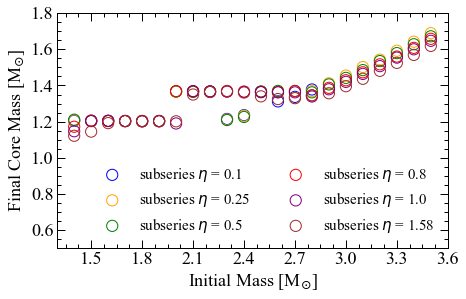

In [151]:
make_canvas(clear=True)
s=500

fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'Final Core Mass [M$_{\odot}$]')

ax.set_xlim(1.3, 3.6)
ax.set_ylim(0.5, 1.8)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())



ax.scatter(init_mass_eta0p1, final_core_mass_eta0p1, marker = '.', facecolors='none', edgecolors='blue',
           s = s, alpha=1.0, label = r'subseries $\eta$ = 0.1')
ax.scatter(init_mass_eta0p25, final_core_mass_eta0p25, marker = '.', facecolors='none', edgecolors='orange',
           s = s,alpha=1.0, label = r'subseries $\eta$ = 0.25')
ax.scatter(init_mass_eta0p5, final_core_mass_eta0p5, marker = '.', facecolors='none', edgecolors='green',
           s = s,alpha=1.0, label = r'subseries $\eta$ = 0.5')
ax.scatter(init_mass_eta0p8, final_core_mass_eta0p8, marker = '.', facecolors='none', edgecolors='red',
           s = s,alpha=1.0, label = r'subseries $\eta$ = 0.8')
ax.scatter(init_mass_eta1p0, final_core_mass_eta1p0, marker = '.', facecolors='none',  edgecolors='purple',
           s = s,alpha=1.0, label = r'subseries $\eta$ = 1.0')
ax.scatter(init_mass_eta1p58, final_core_mass_eta1p58, marker = '.', facecolors='none',edgecolors='brown',
           s = s,alpha=1.0, label = r'subseries $\eta$ = 1.58')

legend = ax.legend(loc = 'lower right', ncol=2, shadow = False, frameon=False, prop={'size':15})

# plt.savefig(os.path.join(plot_results_dir, 'series2_coreGrowth.pdf'), dpi=300, bbox_inches='tight')

<Figure size 504x311.489 with 0 Axes>

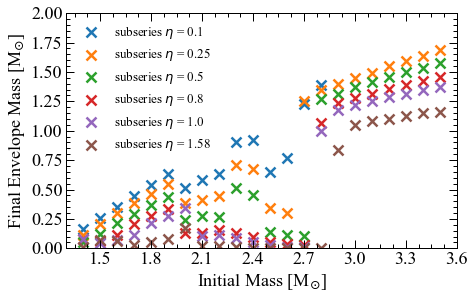

In [140]:
make_canvas(clear=True)
s=100

fig, ax = plt.subplots()
ax.set_xlabel(r'Initial Mass [M$_{\odot}$]')
ax.set_ylabel(r'Final Envelope Mass [M$_{\odot}$]')

ax.set_xlim(1.3, 3.6)
ax.set_ylim(0.0, 2.0)

ax.tick_params(direction='in', which='major', axis='both', length=8, width=1, top=True, right=True)
ax.tick_params(direction='in', which='minor', axis='both', length=4, width=1, top=True, right=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.scatter(init_mass_eta0p1, envelope_mass_eta0p1, marker = 'x',
           s = s, alpha=1.0, label = r'subseries $\eta$ = 0.1')
ax.scatter(init_mass_eta0p25, envelope_mass_eta0p25, marker = 'x',
           s = s,alpha=1.0, label = r'subseries $\eta$ = 0.25')
ax.scatter(init_mass_eta0p5, envelope_mass_eta0p5, marker = 'x', 
           s = s,alpha=1.0, label = r'subseries $\eta$ = 0.5')
ax.scatter(init_mass_eta0p8, envelope_mass_eta0p8, marker = 'x', 
           s = s,alpha=1.0, label = r'subseries $\eta$ = 0.8')
ax.scatter(init_mass_eta1p0, envelope_mass_eta1p0, marker = 'x', 
           s = s,alpha=1.0, label = r'subseries $\eta$ = 1.0')
ax.scatter(init_mass_eta1p58, envelope_mass_eta1p58, marker = 'x', 
           s = s,alpha=1.0, label = r'subseries $\eta$ = 1.58')

legend = ax.legend(loc = 'upper left', ncol=1, shadow = False, frameon=False, prop={'size':13})

# plt.savefig(os.path.join(plot_results_dir, 'series2_envelopeMass.pdf'), dpi=300, bbox_inches='tight')

## Abundance profiles